In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os, gc
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows",200)
pd.set_option("display.max_columns",100)


In [ ]:
train_df = pd.read_csv('store_data/new_feat/train_df_feat.csv')
test_df  = pd.read_csv('store_data/new_feat/test_df_feat.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')
train_df.shape, test_df.shape, sub.shape, info_df.shape

((233154, 55), (112392, 54), (112392, 2), (41, 3))

In [ ]:
train_df1 = pd.read_csv('train_aox2Jxw/train.csv')
test_df1  = pd.read_csv('test_bqCt9Pv.csv')

train_df1 = train_df1[['UniqueID']]
test_df1 = test_df1[['UniqueID']]

train_df1.shape, test_df1.shape

In [2]:
train_df = pd.read_csv('train_aox2Jxw/train.csv')
test_df  = pd.read_csv('test_bqCt9Pv.csv')
sub      = pd.read_csv('sample_submission_24jSKY6.csv')
info_df  = pd.read_excel('train_aox2Jxw/Data Dictionary.xlsx')

train_test = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

train_test.shape, train_df.shape, test_df.shape, sub.shape, info_df.shape

((345546, 41), (233154, 41), (112392, 40), (112392, 2), (41, 3))

# Only `Employment.Type` have `NaN` values

## Add flag to diffrentiate b/w train and test

In [3]:
def distplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,4))
    sns.distplot(df[df[flag_col] == 1][col], hist=False, label='train')
    sns.distplot(df[df[flag_col] == 0][col], hist=False, label='test')
    _ = plt.xticks(rotation='vertical')
    
def countplot_it(df, flag_col, col):
    """
    Args:
        df      : data-frame
        col     : columnn for distplot
        flag_col: flag to represent train or test
    return: 
        distplot with flag[0/1]
    """
    plt.figure(figsize=(16,4))
    sns.countplot(x=col, hue=flag_col, data=train_test)
    _ = plt.xticks(rotation='vertical')
    


In [4]:
def remove_and_fill_outlier(df, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df, q=1)
    upper_bound = np.percentile(df, q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    if flag == 'upper':
        new = np.where(df>upper_bound, np.nan, df)
    elif flag == 'lower':
        new = np.where(df<lower_bound, np.nan, df)
    else: # when both are selected
        new = np.where(df>upper_bound, np.nan, df)
        new = np.where(new<lower_bound, np.nan, new)
    print("null count: ", pd.DataFrame(new).isnull().sum().values)
    return new

def get_quantile(df, col, q1, q2):
    lower_bound = np.percentile(df[col], q=q1)
    upper_bound = np.percentile(df[col], q=q2)
    print("low: ", lower_bound)
    print("high: ", upper_bound)
    
def remove_outlier(df, col, flag):
    """fill outlier with the nan values"""
    """
    Args:
        df  : feature
        flag: string ['lower','upper','both']
    return: array containing new feature
    """
    lower_bound = np.percentile(df[col], q=1)
    upper_bound = np.percentile(df[col], q=99)
    print("low: ", np.round(lower_bound,2), "   high: ", np.round(upper_bound,2))
    print("check shape: ", df.shape[0], "==>", end=" ")
    if flag == 'upper':
        df = df[df[col]<upper_bound]
    elif flag == 'lower':
        df = df[df[col]>lower_bound]
    else: # when both are selected
        df = df[df[col]<upper_bound]
        df = df[df[col]>lower_bound]
    print(df.shape[0])
    return d

# Handling `12` catgorical variables

In [5]:
train_test['train_flag'] = 0
train_test['train_flag'].iloc[:train_df.shape[0]] = 1
train_test.train_flag.value_counts()

1    233154
0    112392
Name: train_flag, dtype: int64

In [6]:
train_test['Date.of.Birth'] = train_test['Date.of.Birth'].apply(
    lambda x: str(x)[:-2]+'20'+str(x)[-2:] if str(x)[-2:] == '00' \
    else str(x)[:-2]+'19'+str(x)[-2:])
train_test['date_of_birth']  = pd.to_datetime(pd.Series(train_test['Date.of.Birth']))
train_test.drop('Date.of.Birth', axis=1, inplace=True)

In [7]:
train_test['DisbursalDate_new'] = pd.to_datetime(
    pd.Series(train_test['DisbursalDate'].apply(lambda x: str(x)[:-3])), 
    format="%d-%m")

train_test.DisbursalDate_new = train_test.DisbursalDate_new.apply(
    lambda dt: dt.replace(year=2018))

train_test['disbursal_week']  = train_test['DisbursalDate_new'].dt.week
train_test['disbursal_day']   = train_test['DisbursalDate_new'].dt.day
train_test['disbursal_month'] = train_test['DisbursalDate_new'].dt.month

# train_test.DisbursalDate_new.unique()

In [8]:
train_test['age(in years)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/365) / np.timedelta64(1, 'D')
train_test['age(in years)'] = train_test['age(in years)'].astype('int')
print(train_test['age(in years)'][:5])

train_test['age(in month)'] = ((train_test['DisbursalDate_new'] - \
                    train_test['date_of_birth'])/30) / np.timedelta64(1, 'D')
train_test['age(in month)'] = train_test['age(in years)'].astype('int')
print(train_test['age(in month)'][:5])

0    34
1    33
2    32
3    24
4    41
Name: age(in years), dtype: int64
0    34
1    33
2    32
3    24
4    41
Name: age(in month), dtype: int64


In [9]:
train_test['credit_hist_year'] = train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[0][:-3])
train_test['credit_hist_month']= train_test['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.split(' ')[1][:-3])

train_test['credit_hist_year'] = train_test['credit_hist_year'].astype('int')
train_test['credit_hist_month']= train_test['credit_hist_month'].astype('int')

train_test['credit_hist_total_month']= train_test['credit_hist_month'] + \
                                        train_test['credit_hist_year']*12

train_test['loan_tenure_year'] = train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[0][:-3])
train_test['loan_tenure_month']= train_test['AVERAGE.ACCT.AGE'].apply(lambda x: x.split(' ')[1][:-3])

train_test['loan_tenure_year'] = train_test['loan_tenure_year'].astype('int')
train_test['loan_tenure_month']= train_test['loan_tenure_month'].astype('int')

train_test['loan_tenure_total_month']= train_test['loan_tenure_month'] + \
                                        train_test['loan_tenure_year']*12

# train_test.drop(['AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1, inplace=True)


In [10]:
train_test['Employment.Type'].fillna('Self employed', inplace=True)


In [11]:
col = 'PRI.NO.OF.ACCTS'
new_col = 'pri_no_of_accts'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,8),(8,15),(15,1000)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.drop(col, axis=1, inplace=True)
train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()


(-1, 0]       174843
(0, 1]         51914
(4, 8]         30184
(1, 2]         29253
(2, 3]         19409
(8, 15]        17566
(3, 4]         13758
(15, 1000]      8619
Name: pri_no_of_accts, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 8, closed='right')
 Interval(8, 15, closed='right') Interval(15, 1000, closed='right')]


loan_default,0.0,1.0
pri_no_of_accts,,
0,89898,27052
1,27241,7737
2,15535,4249
3,10377,2638
4,7535,1788
5,16791,3969
6,10026,2176
7,5140,1002


In [12]:
col = 'PRI.ACTIVE.ACCTS'

bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,3),(3,6),(6,10),(10,500)])
train_test['no_of_acc'] = pd.cut(train_test[col], bins)
print(train_test['no_of_acc'].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test['no_of_acc'] = le.fit_transform(train_test['no_of_acc'])
print(le.classes_)

train_test.drop(col, axis=1, inplace=True)
train_test.groupby(['no_of_acc','loan_default'])['loan_default'].count().unstack()

(-1, 0]      205427
(0, 1]        62095
(1, 3]        49528
(3, 6]        21052
(6, 10]        5835
(10, 500]      1609
Name: no_of_acc, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 3, closed='right') Interval(3, 6, closed='right')
 Interval(6, 10, closed='right') Interval(10, 500, closed='right')]


loan_default,0.0,1.0
no_of_acc,,
0,105965,31051
1,32873,9182
2,26821,6996
3,12173,2617
4,3659,609
5,1052,156


In [13]:
col = 'PRI.OVERDUE.ACCTS'
new_col = 'no_of_acc_overdue'
bins = pd.IntervalIndex.from_tuples([(-1, 0),(0, 1),(1,2),(2,5),(5,500)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)
print(train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack())

train_test.drop(col, axis=1, inplace=True)


(-1, 0]     306917
(0, 1]       29378
(1, 2]        6275
(2, 5]        2642
(5, 500]       334
Name: no_of_acc_overdue, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 5, closed='right')
 Interval(5, 500, closed='right')]
loan_default          0.0    1.0
no_of_acc_overdue               
0                  163471  43408
1                   14588   5382
2                    3061   1241
3                    1243    529
4                     180     51


In [14]:
train_test.drop('MobileNo_Avl_Flag', axis=1, inplace=True)


In [15]:
# bureau description and corresponding score
mapping = {
        'No Bureau History Available'                            :'not_enough_info',# 00
        'Not Scored: More than 50 active Accounts found'         :'not_enough_info',# 11
        'Not Scored: No Activity seen on the customer (Inactive)':'not_enough_info',# 16
        'Not Scored: No Updates available in last 36 months'     :'not_enough_info',# 18 
        'Not Scored: Not Enough Info available on the customer'  :'not_enough_info',# 17
        'Not Scored: Only a Guarantor'                           :'not_enough_info',# 14
        'Not Scored: Sufficient History Not Available'           :'not_enough_info' # 15
       }

train_test['Bureau_desc'] = train_test['PERFORM_CNS.SCORE.DESCRIPTION'].replace(mapping)

use_index = train_test[['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE']][
    train_test['Bureau_desc'] == 'not_enough_info']['PERFORM_CNS.SCORE'].index
train_test['bureau_score'] = train_test['PERFORM_CNS.SCORE']
train_test.loc[use_index,'bureau_score'] = 0


train_test.drop(['PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'], 
                axis=1, inplace=True)


In [16]:
col = 'NEW.ACCTS.IN.LAST.SIX.MONTHS'
new_col = 'new_acc_past_month'

bins = pd.IntervalIndex.from_tuples([(-1,0),(0,1),(1,2),(2,3),(3,4),(4,50)])
train_test[new_col] = pd.cut(train_test[col], bins)
print(train_test[new_col].value_counts())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_test[new_col] = le.fit_transform(train_test[new_col])
print(le.classes_)

train_test.groupby([new_col,'loan_default'])['loan_default'].count().unstack()
train_test.drop(col, axis=1, inplace=True)

(-1, 0]    272341
(0, 1]      45965
(1, 2]      15618
(2, 3]       6161
(4, 50]      2825
(3, 4]       2636
Name: new_acc_past_month, dtype: int64
[Interval(-1, 0, closed='right') Interval(0, 1, closed='right')
 Interval(1, 2, closed='right') Interval(2, 3, closed='right')
 Interval(3, 4, closed='right') Interval(4, 50, closed='right')]


# numeric columns

In [17]:
def print_it(col):
    print(col)
    print("train-test:")
    get_quantile(train_test,col,q1,q2)
    print("train_df  :")
    get_quantile(train_df,col,q1,q2)
    print("*"*30)

q1 = 1
q2 = 99

col = 'PRI.SANCTIONED.AMOUNT'; print_it(col)
col = 'PRI.DISBURSED.AMOUNT'; print_it(col)
col = 'PRI.SANCTIONED.AMOUNT'; print_it(col)
col = 'PRI.DISBURSED.AMOUNT'; print_it(col)
col = 'PRI.CURRENT.BALANCE'; print_it(col)
col = 'SEC.CURRENT.BALANCE'; print_it(col)
col = 'SEC.DISBURSED.AMOUNT'; print_it(col)
col = 'PRIMARY.INSTAL.AMT'; print_it(col)
col = 'SEC.CURRENT.BALANCE'; print_it(col)



PRI.SANCTIONED.AMOUNT
train-test:
low:  0.0
high:  3363234.2999999993
train_df  :
low:  0.0
high:  3467119.3700000034
******************************
PRI.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  3366855.2999999924
train_df  :
low:  0.0
high:  3457573.880000001
******************************
PRI.SANCTIONED.AMOUNT
train-test:
low:  0.0
high:  3363234.2999999993
train_df  :
low:  0.0
high:  3467119.3700000034
******************************
PRI.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  3366855.2999999924
train_df  :
low:  0.0
high:  3457573.880000001
******************************
PRI.CURRENT.BALANCE
train-test:
low:  0.0
high:  2835998.64999999
train_df  :
low:  0.0
high:  2917864.330000001
******************************
SEC.CURRENT.BALANCE
train-test:
low:  0.0
high:  6226.499999999884
train_df  :
low:  0.0
high:  19733.780000000086
******************************
SEC.DISBURSED.AMOUNT
train-test:
low:  0.0
high:  30397.29999999993
train_df  :
low:  0.0
high:  47544.83000000022
***

In [18]:
train_test.shape, train_df.shape, test_df.shape, train_df.shape[0]+test_df.shape[0]

((345546, 53), (233154, 41), (112392, 40), 345546)

In [19]:
def replace_outliers(df, low, high):
    """
    Args:
        df  : array
        low : 01% range
        high: 99% range
    return:
        an array, where outliers are replaced by the end ranges
    """
    df = np.where(df>high, high, df)
    df = np.where(df<low, low, df)
    print(df)
    
x = [1,2,3,4,54,5,7,78,9,9,33,5,6,9]
replace_outliers(np.array(x), 3,7)

[3 3 3 4 7 5 7 7 7 7 7 5 6 7]


In [20]:
df = pd.DataFrame(data=x, columns=['x'])
print(x)
df[df.x > 7] = 7
df[df.x < 3] = 3
df

[1, 2, 3, 4, 54, 5, 7, 78, 9, 9, 33, 5, 6, 9]


,x
0,3
1,3
2,3
3,4
4,7
5,5
6,7
7,7
8,7
9,7


In [21]:
def count_negative(df, col):
    print(col, "==", df[df[col]<0].shape[0])
print("count negative numbers")

col = 'PRI.SANCTIONED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.SANCTIONED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRI.CURRENT.BALANCE'; count_negative(train_test, col)
col = 'SEC.CURRENT.BALANCE'; count_negative(train_test, col)
col = 'SEC.DISBURSED.AMOUNT'; count_negative(train_test, col)
col = 'PRIMARY.INSTAL.AMT'; count_negative(train_test, col)
col = 'SEC.CURRENT.BALANCE'; count_negative(train_test, col)



count negative numbers
PRI.SANCTIONED.AMOUNT == 1
PRI.DISBURSED.AMOUNT == 0
PRI.SANCTIONED.AMOUNT == 1
PRI.DISBURSED.AMOUNT == 0
PRI.CURRENT.BALANCE == 666
SEC.CURRENT.BALANCE == 66
SEC.DISBURSED.AMOUNT == 0
PRIMARY.INSTAL.AMT == 0
SEC.CURRENT.BALANCE == 66


In [22]:
def print_it(col):
    print(col)
#     print("train-test:")
    get_quantile(train_test,col,q1,q2)
#     print("train_df  :")
#     get_quantile(train_df,col,q1,q2)
    print("*"*30)

q1 = 1
q2 = 99

col = 'PRI.SANCTIONED.AMOUNT'; print_it(col)
col = 'PRI.DISBURSED.AMOUNT'; print_it(col)
col = 'PRI.SANCTIONED.AMOUNT'; print_it(col)
col = 'PRI.DISBURSED.AMOUNT'; print_it(col)
col = 'PRI.CURRENT.BALANCE'; print_it(col)
col = 'SEC.CURRENT.BALANCE'; print_it(col)
col = 'SEC.DISBURSED.AMOUNT'; print_it(col)
col = 'PRIMARY.INSTAL.AMT'; print_it(col)
col = 'SEC.CURRENT.BALANCE'; print_it(col)

PRI.SANCTIONED.AMOUNT
low:  0.0
high:  3363234.2999999993
******************************
PRI.DISBURSED.AMOUNT
low:  0.0
high:  3366855.2999999924
******************************
PRI.SANCTIONED.AMOUNT
low:  0.0
high:  3363234.2999999993
******************************
PRI.DISBURSED.AMOUNT
low:  0.0
high:  3366855.2999999924
******************************
PRI.CURRENT.BALANCE
low:  0.0
high:  2835998.64999999
******************************
SEC.CURRENT.BALANCE
low:  0.0
high:  6226.499999999884
******************************
SEC.DISBURSED.AMOUNT
low:  0.0
high:  30397.29999999993
******************************
PRIMARY.INSTAL.AMT
low:  0.0
high:  240000.0
******************************
SEC.CURRENT.BALANCE
low:  0.0
high:  6226.499999999884
******************************


In [23]:
col = 'PRI.SANCTIONED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col] < 0][col] = 0
train_test[train_test[col] > 3363234][col] = 3363234
print(train_test.shape)

col = 'PRI.DISBURSED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col] < 0][col] = 0
train_test[train_test[col] > 3366855][col] = 3366855
print(train_test.shape)

col = 'PRI.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>2835998][col] = 2835998
print(train_test.shape)

col = 'SEC.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>6226][col] = 6226
print(train_test.shape)

col = 'SEC.DISBURSED.AMOUNT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>30397][col] = 30397
print(train_test.shape)

col = 'SEC.CURRENT.BALANCE'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0 
train_test[train_test[col]>6226.5][col] = 6226.5
print(train_test.shape)

col = 'PRIMARY.INSTAL.AMT'

print(train_test.shape, "==>", end=" ")
train_test[train_test[col]<0][col] = 0
train_test[train_test[col]>240000][col] = 240000
print(train_test.shape)


(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)
(345546, 53) ==> (345546, 53)


In [24]:
col1 = 'PRI.SANCTIONED.AMOUNT'
col2 = 'PRI.DISBURSED.AMOUNT'
train_test['pay_by_yourself'] = train_test[col2] - train_test[col1]

new_col1 = 'obtained_amount_per_month'
new_col2 = 'obtained_amount_per_year'
train_test[new_col1] = train_test[col2]/(1 + train_test['loan_tenure_total_month'])
train_test[new_col2] = train_test[col2]/(1 + train_test['loan_tenure_year'])


In [25]:
print(train_test.shape[0], "==>", end=" ")
drop_cols = ['SEC.OVERDUE.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.NO.OF.ACCTS', 'VoterID_flag', 
             'Driving_flag', 'Passport_flag', 'SEC.INSTAL.AMT']
train_test.drop(drop_cols, axis=1, inplace=True)
print(train_test.shape[0])

345546 ==> 345546


In [26]:
############## Simple aggregation w/o time compomnenet###########
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id'],how='left')

print(train_test.shape)


(345546, 49) ==> (345546, 52)


# Aggregation with time compomnenet
    - It have different distribution for train and test

In [27]:
############## Aggregation with time compomnenet ###########

print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id','disbursal_week'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID','disbursal_week'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id','disbursal_week'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_week_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id','disbursal_week'],how='left')

print(train_test.shape)

(345546, 52) ==> (345546, 55)


## aggregation date wise

In [28]:
train_test1 = train_test.copy()
############## Simple aggregation w/o time compomnenet###########
print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_disbursedDate_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['DisbursalDate_new'],how='left')

print(train_test.shape)


(345546, 55) ==> (345546, 58)


In [29]:
############## Aggregation with time compomnenet ###########

print(train_test.shape, "==>", end=" ")

####################### manufacturer_id Mean #######################
branch_gps = train_test.groupby(['manufacturer_id','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['manufac_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['manufacturer_id','DisbursalDate_new'],how='left')

####################### State_ID Mean #######################
branch_gps = train_test.groupby(['State_ID','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['state_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['State_ID','DisbursalDate_new'],how='left')

####################### branch_id Mean #######################
branch_gps = train_test.groupby(['branch_id','DisbursalDate_new'])[
    'disbursed_amount'].aggregate(['mean'])
branch_gps.columns = ['branch_date_disbursed_mean']
train_test = pd.merge(train_test, branch_gps, 
                      on=['branch_id','DisbursalDate_new'],how='left')

print(train_test.shape)

(345546, 58) ==> (345546, 61)


In [31]:
stat_cols = ['PRI.CURRENT.BALANCE','PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT',
             'PRIMARY.INSTAL.AMT','asset_cost','disbursed_amount']

print(train_test.shape, "==>", end=" ")

train_test['stat_mean']   = train_test[stat_cols].mean(axis=1)
train_test['stat_median'] = train_test[stat_cols].median(axis=1)
train_test['stat_skew']   = train_test[stat_cols].skew(axis=1)
train_test['stat_std']    = train_test[stat_cols].std(axis=1)
print(train_test.shape)

(345546, 65) ==> (345546, 65)


In [32]:
assert train_test.shape[0] == train_df.shape[0]+test_df.shape[0]
print("shape are equal")

shape are equal


In [33]:
branch_gping = train_test.groupby(['DisbursalDate','branch_id','Employee_code_ID'])[
    'disbursed_amount', 'ltv','asset_cost'].mean()
branch_gping.columns = ['date_branch_emp_disbursed_amount', 'date_branch_emp_ltv', 
                        'date_branch_emp_asset_cost']

print(train_test.shape, "==>", end=" ")
train_test = pd.merge(train_test, branch_gping, 
                      on=['DisbursalDate','branch_id','Employee_code_ID'],
                      how='left')
print(train_test.shape)


(345546, 65) ==> (345546, 68)


In [33]:
train_test.to_csv('store_data/train_test_save7.csv', index=None)

In [34]:
drop_cols = ['date_of_birth', 'Employee_code_ID','DisbursalDate',
             'CREDIT.HISTORY.LENGTH', 'AVERAGE.ACCT.AGE', 'DisbursalDate_new']

train_test.drop(drop_cols, axis=1, inplace=True)
train_test.head()

,Aadhar_flag,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Employment.Type,NO.OF_INQUIRIES,PAN_flag,PRI.CURRENT.BALANCE,PRI.DISBURSED.AMOUNT,PRI.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,SEC.SANCTIONED.AMOUNT,State_ID,UniqueID,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id,supplier_id,train_flag,disbursal_week,disbursal_day,disbursal_month,age(in years),age(in month),credit_hist_year,credit_hist_month,credit_hist_total_month,loan_tenure_year,loan_tenure_month,loan_tenure_total_month,pri_no_of_accts,no_of_acc,no_of_acc_overdue,Bureau_desc,bureau_score,new_acc_past_month,pay_by_yourself,obtained_amount_per_month,obtained_amount_per_year,manufac_disbursed_mean,state_disbursed_mean,branch_disbursed_mean,manufac_week_disbursed_mean,state_week_disbursed_mean,branch_week_disbursed_mean,manufac_disbursedDate_mean,state_disbursedDate_mean,branch_disbursedDate_mean,manufac_date_disbursed_mean,state_date_disbursed_mean,branch_date_disbursed_mean,stat_mean,stat_median,stat_skew,stat_std,date_branch_emp_disbursed_amount,date_branch_emp_ltv,date_branch_emp_asset_cost
0,1,1441,0,Salaried,0,0,0,0,0,0,0,0,0,6,420825,58400,67,50578,0.0,89.55,45,22807,1,31,3,8,34,34,0,0,0,0,0,0,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51740.371549,51740.371549,51740.371549,46174.107895,49978.261224,50470.271429,18163.000000,0.0,1.001508,28246.510121,50578.0,89.55,58400.0
1,1,1502,1,Self employed,0,0,27600,50200,50200,1991,0,0,0,6,537409,65550,67,47145,1.0,73.23,45,22807,1,39,26,9,33,33,1,11,23,1,11,23,1,1,1,I-Medium Risk,598,0,0,2091.666667,25100.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,40447.666667,48672.5,-1.094696,22401.674818,49761.5,80.81,62925.0
2,1,1497,0,Self employed,0,0,0,0,0,0,0,0,0,6,417566,61360,67,53278,0.0,89.63,45,22807,1,31,1,8,32,32,0,0,0,0,0,0,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51430.433841,51430.433841,51430.433841,45514.829730,48707.741525,51593.740000,19106.333333,0.0,1.000350,29709.537335,53278.0,89.63,61360.0
3,1,1501,0,Self employed,1,0,0,0,0,31,0,0,0,6,624493,66113,67,57513,1.0,88.48,45,22807,1,43,26,10,24,24,1,3,15,0,8,8,3,0,0,L-Very High Risk,305,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,51074.109043,52919.600166,53079.192621,56431.085599,56431.085599,56431.085599,51439.126253,53916.178801,54048.882812,20609.500000,15.5,0.999520,32031.752863,57513.0,88.48,66113.0
4,1,1495,0,Self employed,1,0,0,0,0,0,0,0,0,6,539055,60300,67,52378,1.0,88.39,45,22807,1,39,26,9,41,41,0,0,0,0,0,0,0,0,0,not_enough_info,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,18779.666667,0.0,1.000176,29200.991775,49761.5,80.81,62925.0


In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col = 'Bureau_desc'
train_test[col] = le.fit_transform(train_test[col])
print(le.classes_)
col = 'Employment.Type'
train_test[col] = le.fit_transform(train_test[col])
print(le.classes_)

['A-Very Low Risk' 'B-Very Low Risk' 'C-Very Low Risk' 'D-Very Low Risk'
 'E-Low Risk' 'F-Low Risk' 'G-Low Risk' 'H-Medium Risk' 'I-Medium Risk'
 'J-High Risk' 'K-High Risk' 'L-Very High Risk' 'M-Very High Risk'
 'not_enough_info']
['Salaried' 'Self employed']


In [36]:
tr_shape = train_df.shape[0]
ts_shape = test_df.shape[0]

del train_df, test_df
gc.collect()

train_test.head()

,Aadhar_flag,Current_pincode_ID,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Employment.Type,NO.OF_INQUIRIES,PAN_flag,PRI.CURRENT.BALANCE,PRI.DISBURSED.AMOUNT,PRI.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.CURRENT.BALANCE,SEC.DISBURSED.AMOUNT,SEC.SANCTIONED.AMOUNT,State_ID,UniqueID,asset_cost,branch_id,disbursed_amount,loan_default,ltv,manufacturer_id,supplier_id,train_flag,disbursal_week,disbursal_day,disbursal_month,age(in years),age(in month),credit_hist_year,credit_hist_month,credit_hist_total_month,loan_tenure_year,loan_tenure_month,loan_tenure_total_month,pri_no_of_accts,no_of_acc,no_of_acc_overdue,Bureau_desc,bureau_score,new_acc_past_month,pay_by_yourself,obtained_amount_per_month,obtained_amount_per_year,manufac_disbursed_mean,state_disbursed_mean,branch_disbursed_mean,manufac_week_disbursed_mean,state_week_disbursed_mean,branch_week_disbursed_mean,manufac_disbursedDate_mean,state_disbursedDate_mean,branch_disbursedDate_mean,manufac_date_disbursed_mean,state_date_disbursed_mean,branch_date_disbursed_mean,stat_mean,stat_median,stat_skew,stat_std,date_branch_emp_disbursed_amount,date_branch_emp_ltv,date_branch_emp_asset_cost
0,1,1441,0,0,0,0,0,0,0,0,0,0,0,6,420825,58400,67,50578,0.0,89.55,45,22807,1,31,3,8,34,34,0,0,0,0,0,0,0,0,0,13,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51740.371549,51740.371549,51740.371549,46174.107895,49978.261224,50470.271429,18163.000000,0.0,1.001508,28246.510121,50578.0,89.55,58400.0
1,1,1502,1,1,0,0,27600,50200,50200,1991,0,0,0,6,537409,65550,67,47145,1.0,73.23,45,22807,1,39,26,9,33,33,1,11,23,1,11,23,1,1,1,8,598,0,0,2091.666667,25100.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,40447.666667,48672.5,-1.094696,22401.674818,49761.5,80.81,62925.0
2,1,1497,0,1,0,0,0,0,0,0,0,0,0,6,417566,61360,67,53278,0.0,89.63,45,22807,1,31,1,8,32,32,0,0,0,0,0,0,0,0,0,13,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,46057.862745,49444.791667,50931.649718,51430.433841,51430.433841,51430.433841,45514.829730,48707.741525,51593.740000,19106.333333,0.0,1.000350,29709.537335,53278.0,89.63,61360.0
3,1,1501,0,1,1,0,0,0,0,31,0,0,0,6,624493,66113,67,57513,1.0,88.48,45,22807,1,43,26,10,24,24,1,3,15,0,8,8,3,0,0,11,305,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,51074.109043,52919.600166,53079.192621,56431.085599,56431.085599,56431.085599,51439.126253,53916.178801,54048.882812,20609.500000,15.5,0.999520,32031.752863,57513.0,88.48,66113.0
4,1,1495,0,1,1,0,0,0,0,0,0,0,0,6,539055,60300,67,52378,1.0,88.39,45,22807,1,39,26,9,41,41,0,0,0,0,0,0,0,0,0,13,0,0,0,0.000000,0.0,49787.567424,52013.951394,52479.194149,50363.817038,52137.326040,52618.855381,55268.452152,55268.452152,55268.452152,50183.237553,51734.682505,52383.056738,18779.666667,0.0,1.000176,29200.991775,49761.5,80.81,62925.0


In [37]:
train_df = train_test.iloc[:tr_shape, :]
test_df = train_test.iloc[tr_shape:, :]
test_df.reset_index(drop=True, inplace=True)

tr_unique_ids = train_df.UniqueID
ts_unique_ids = test_df.UniqueID

train_df.shape, test_df.shape

((233154, 62), (112392, 62))

In [38]:
target = train_df['loan_default']

train_df.drop(['loan_default','train_flag','UniqueID'], axis=1, inplace=True)
test_df.drop(['loan_default','train_flag','UniqueID'], axis=1, inplace=True)

train_df.shape, test_df.shape

((233154, 59), (112392, 59))

In [37]:
train_test.dtypes

Aadhar_flag                              int64
Current_pincode_ID                       int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      int64
Employment.Type                          int64
NO.OF_INQUIRIES                          int64
PAN_flag                                 int64
PRI.CURRENT.BALANCE                      int64
PRI.DISBURSED.AMOUNT                     int64
PRI.SANCTIONED.AMOUNT                    int64
PRIMARY.INSTAL.AMT                       int64
SEC.CURRENT.BALANCE                      int64
SEC.DISBURSED.AMOUNT                     int64
SEC.SANCTIONED.AMOUNT                    int64
State_ID                                 int64
UniqueID                                 int64
asset_cost                               int64
branch_id                                int64
disbursed_amount                         int64
loan_default                           float64
ltv                                    float64
manufacturer_id                          int64
supplier_id  

In [39]:
print(train_df.shape, test_df.shape, "==>", end=" ")
train_df.drop(['disbursal_week', 'disbursal_day'], axis=1, inplace=True)
test_df.drop(['disbursal_week', 'disbursal_day'], axis=1, inplace=True)
print(train_df.shape, test_df.shape)


(233154, 59) (112392, 59) ==> (233154, 57) (112392, 57)


In [49]:
tr_unique_ids = train_df1.UniqueID
ts_unique_ids = test_df1.UniqueID

target = train_df['loan_default']

train_df.drop('loan_default', axis=1, inplace=True)

del train_df1, test_df1
gc.collect()

train_df.shape, test_df.shape, target.shape

NameError: name 'train_df1' is not defined

8008

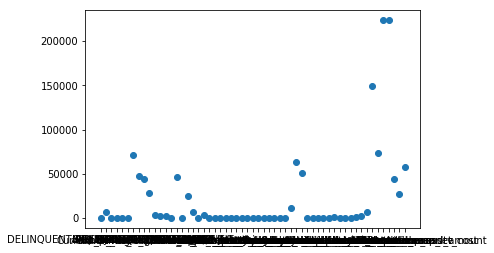

In [43]:
cols = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0]).index
values = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0]).values
plt.plot(cols, values, 'o')

complete_df = pd.concat([train_df, test_df], axis=0)

for col,value in zip(cols,values):
    if value>10 or value<300:
        q1 = 15
        complete_df[col] = pd.qcut(complete_df[col], q=q1, 
                                  retbins=False, duplicates='drop')
    elif value>300 or value<10000:
        q1 = 50
        complete_df[col] = pd.qcut(complete_df[col], q=q1, 
                                  retbins=False, duplicates='drop')
    elif value>10000:# or value<10000:
        q1 = 100
        complete_df[col] = pd.qcut(complete_df[col], q=q1, 
                                  retbins=False, duplicates='drop')
    else:
        pass
    
train_df = complete_df.iloc[:train_df.shape[0],:]
test_df  = complete_df.iloc[train_df.shape[0]:,:]
del complete_df
gc.collect()

In [45]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [46]:
def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, lgb_imp
    
    
def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostClassifier(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict_proba(X_valid[features])[:,1]
    test_pred  = clf.predict_proba(X_test[features])[:,1]

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


In [47]:
# def run_xgb(splits, file_path, train_df, target, test_df, test_id, sub, depth):
def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'auc',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
        'Scale_pos_weight': 3.607,
        'objective'       : 'binary:logistic',
        'max_depth'       : depth,
        'alpha'           : 0.05
    }
    
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print("="*60)
    
    return clfs, feature_imp, oof_xgb, predictions


In [48]:
def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "Logloss", 
        'eval_metric'           : "AUC",
        'random_strength'       : 1.5,
        'border_count'          : 128,
        'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.09,
        'thread_count'          : 4
    }


    ##########################
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print("="*60)
    
    return clfs, feature_imp, oof_cat, predictions


In [49]:
def run_cv_lgb(train_df, target, test_df, leaves=None):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'auc',
        'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'binary',
        'verbosity'              : 1,
    #     'lambda_l1'              : 0.001,
        'lambda_l2'              : 0.1
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 3
    num_round = 10000
    feature_imp = pd.DataFrame()
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
#         X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#         X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)

        num_round = 10000
        oof, test_pred, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, param, 
                                                       test_df, num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print("="*60)
    
    return clfs, feature_imp, oof_lgb, predictions

In [50]:

def reduce_mem_usage_wo_print(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    print("="*30)
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory {:.2f} MB'.format(start_mem), "==>", end=" ")
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    # print(col, "== int8")
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    # print(col, "== int16")
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    # print(col, "== int32")
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    # print(col, "== int64")
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    # print(col, "== float16")
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    # print(col, "== float32")
                else:
                    df[col] = df[col].astype(np.float64)
                    # print(col, "== float64")
        #else: df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(' {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print("="*30)
    return 

def make_prediction(file_path, df, test_ids, sub_df):
    """
    Args:
        file_path: file-name with base-path as "submission"
        df: array with shape (test_df.shape[0], cv_fold)
        test_ids: test_ids
        sub_df: submission data-frame
        
    Return:
        output a file with given name
        
    Example: 
    >>> make_prediction(file_path, predictions, ts_unique_ids, sub)
    """
    predictions = np.mean(df, axis=1)
    sub_df = pd.DataFrame({"ID_code":test_ids})
    sub_df["target"] = predictions
    sub_df.columns = sub.columns

    sub_df.to_csv('submission/stacking/{}.csv'.format(file_path), index=None)
    print("successfully saved")
#     print(sub_df.shape)
#     print(sub_df.sample(10))


In [ ]:
# # def run_cv_lgb(file_path, train_df, target, test_df, test_ids, sub, leaves=None):
# def run_cv_fold(train_df, target):
    
#     random_seed = 1234
#     n_splits = 3
    
#     folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    
#     for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
#         print(train_index.shape, valid_index.shape)
#         print("Fold {}".format(fold_))
    
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
#         X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]


In [56]:
reduce_mem_usage_wo_print(train_df)
reduce_mem_usage_wo_print(test_df)

Memory 103.17 MB ==>  33.35 MB
Decreased by 67.7%
Memory 48.88 MB ==>  15.22 MB
Decreased by 68.9%


In [51]:
model_lgb1, imp_lgb1, oof_lgb1, pred_lgb1 = run_cv_lgb(train_df, target, test_df)
make_prediction("lgb11", pred_lgb1, ts_unique_ids, sub)
np.save('submission/stacking/oof_lgb11.npy',oof_lgb1)
del oof_lgb1, pred_lgb1
gc.collect()

(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664642	valid_1's auc: 0.650718
[400]	training's auc: 0.678385	valid_1's auc: 0.655322
[600]	training's auc: 0.690104	valid_1's auc: 0.657452
Early stopping, best iteration is:
[620]	training's auc: 0.691004	valid_1's auc: 0.657515
  auc =  0.657515223308335
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.666173	valid_1's auc: 0.644327
[400]	training's auc: 0.67985	valid_1's auc: 0.649088
[600]	training's auc: 0.691237	valid_1's auc: 0.651963
[800]	training's auc: 0.701537	valid_1's auc: 0.653135
Early stopping, best iteration is:
[804]	training's auc: 0.701719	valid_1's auc: 0.653162
  auc =  0.6531617318932531
(155437,) (77717,)
Fold 2
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.665111	valid_1's auc: 0.646867
[400]	training's auc: 0.678579	valid_1's auc: 0.650825
[600]	t

5197

In [ ]:
# cols = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0]).index
# values = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0]).values
# plt.plot(cols, values, 'o')

# complete_df = pd.concat([train_df, test_df], axis=0)

# for col,value in zip(cols,values):
#     if value>10 or value<300:
#         q1 = 15
#         complete_df[col] = pd.qcut(complete_df[col], q=q1, retbins=False, duplicates='drop')
#     elif value>300:
#         q1 = 50
#         complete_df[col] = pd.qcut(complete_df[col], q=q1, retbins=False, duplicates='drop')
#     else:
#         pass
    
# train_df1 = complete_df.iloc[:train_df.shape[0],:]
# test_df1  = complete_df.iloc[train_df.shape[0]:,:]
# del complete_df_df
# gc.collect()

In [74]:

# model_lgb2, imp_lgb2, oof_lgb2, pred_lgb2 = run_cv_lgb(train_df1, target, test_df1)
# make_prediction("lgb12", pred_lgb2, ts_unique_ids, sub)
# np.save('submission/stacking/oof_lgb12.npy',oof_lgb2)
# del oof_lgb2, pred_lgb2
# gc.collect()

(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664375	valid_1's auc: 0.650851
[400]	training's auc: 0.678412	valid_1's auc: 0.655001
[600]	training's auc: 0.690073	valid_1's auc: 0.657381
Early stopping, best iteration is:
[626]	training's auc: 0.69126	valid_1's auc: 0.657513
  auc =  0.6575126496808865
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.666315	valid_1's auc: 0.643968
[400]	training's auc: 0.679724	valid_1's auc: 0.648783
[600]	training's auc: 0.691216	valid_1's auc: 0.651631
[800]	training's auc: 0.701351	valid_1's auc: 0.652684
[1000]	training's auc: 0.711069	valid_1's auc: 0.653348
Early stopping, best iteration is:
[1090]	training's auc: 0.715353	valid_1's auc: 0.653733
  auc =  0.6537331310250027
(155437,) (77717,)
Fold 2
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.664915	valid_1's auc: 0.646823
[400

51

<BarContainer object of 57 artists>

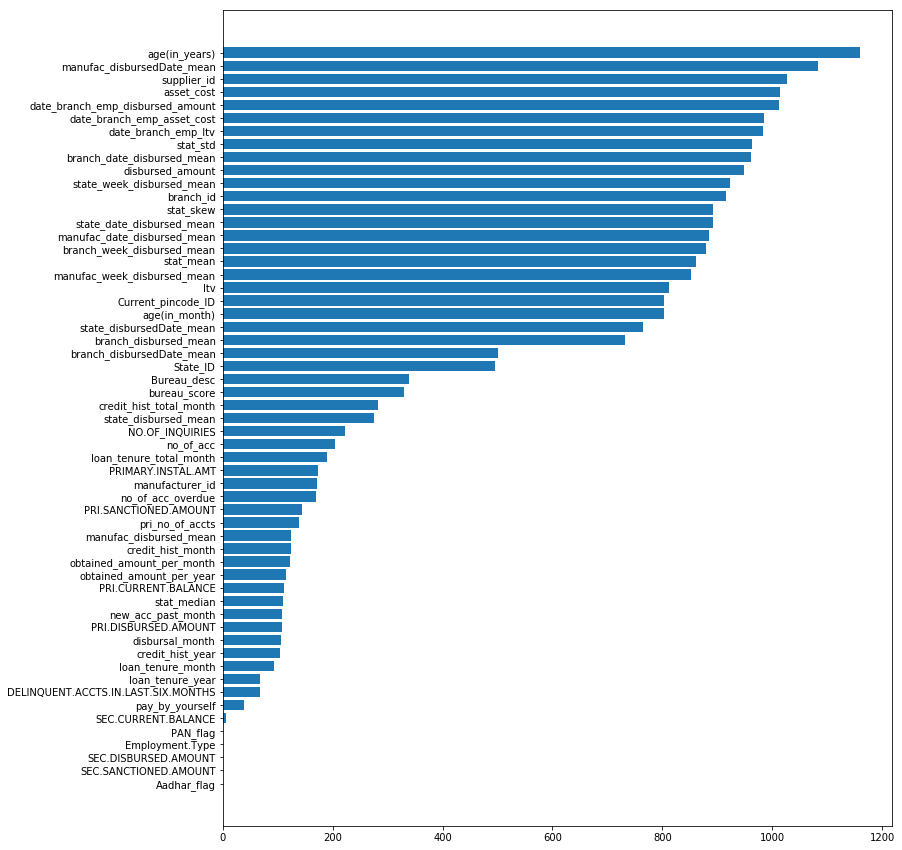

In [75]:
imp_lgb2.imp = imp_lgb2.imp.astype('float')
imp_lgb2 = imp_lgb2.groupby(['feature'])['imp'].mean()
imp_lgb2 = pd.DataFrame(data=[imp_lgb2.index, imp_lgb2.values]).T
imp_lgb2.columns=['feature','imp']
imp_lgb2 = imp_lgb2.sort_values(by='imp')
plt.figure(figsize=(12,15))
plt.barh(imp_lgb2.feature, imp_lgb2.imp)

In [ ]:
# model_lgb2, imp_lgb2, oof_lgb2, pred_lgb2 = run_cv_lgb(train_df, target, test_df)
# make_prediction("lgb12", pred_lgb2, ts_unique_ids, sub)
# np.save('submission/stacking/oof_lgb12.npy',oof_lgb2)
# del oof_lgb2, pred_lgb2
# gc.collect()

In [12]:
# model_lgb1, imp_lgb1, oof_lgb1, pred_lgb1 = run_cv_lgb(train_df, target, test_df)
# make_prediction("lgb1", pred_lgb1, ts_unique_ids, sub)
# np.save('submission/stacking/oof_lgb1.npy',oof_lgb1)
# del oof_lgb1, pred_lgb1
# gc.collect()

(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.667808	valid_1's auc: 0.657709
[400]	training's auc: 0.678375	valid_1's auc: 0.663946
[600]	training's auc: 0.686795	valid_1's auc: 0.667259
[800]	training's auc: 0.693905	valid_1's auc: 0.669241
[1000]	training's auc: 0.700166	valid_1's auc: 0.670262
[1200]	training's auc: 0.705982	valid_1's auc: 0.670901
Early stopping, best iteration is:
[1200]	training's auc: 0.705982	valid_1's auc: 0.670901
  auc =  0.6709009835628708
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.66968	valid_1's auc: 0.653303
[400]	training's auc: 0.680243	valid_1's auc: 0.659157
[600]	training's auc: 0.688356	valid_1's auc: 0.662702
[800]	training's auc: 0.695139	valid_1's auc: 0.664742
[1000]	training's auc: 0.701197	valid_1's auc: 0.666121
[1200]	training's auc: 0.706785	valid_1's auc: 0.666726
[1400]	training's auc: 0.711914	valid_1's 

171

In [56]:
# # def (train_df, target, test_df, depth):
# model_xgb1, imp_xgb1, oof_xgb1, pred_xgb1 = run_cv_xgb(train_df.astype('int'), target,
#                                                        test_df.astype('int'), 4)
# #     train_df.drop('Current_pincode_ID', axis=1), target, 
# #     test_df.drop('Current_pincode_ID', axis=1), 4)
# make_prediction("xgb1", pred_xgb1, ts_unique_ids, sub)
# np.save('submission/stacking/oof_xgb1.npy',oof_xgb1)
# del oof_xgb1, pred_xgb1
gc.collect()

0

In [14]:
# model_cat1, imp_cat1, oof_cat1, pred_cat1 = run_cv_cat(train_df, target, test_df, 4)
# make_prediction("cat1", pred_cat1, ts_unique_ids, sub)
# np.save('submission/stacking/oof_cat1.npy',oof_cat1)
# del oof_cat1, pred_cat1
# gc.collect()

(155435,) (77719,)
Fold 0
0:	test: 0.5966877	test1: 0.5961855	best: 0.5961855 (0)	total: 144ms	remaining: 23m 57s
200:	test: 0.6679750	test1: 0.6628065	best: 0.6628065 (200)	total: 22.4s	remaining: 18m 12s
400:	test: 0.6798027	test1: 0.6667857	best: 0.6667946 (399)	total: 45.4s	remaining: 18m 6s
600:	test: 0.6880208	test1: 0.6683687	best: 0.6683785 (598)	total: 1m 7s	remaining: 17m 37s
800:	test: 0.6949901	test1: 0.6690906	best: 0.6691051 (797)	total: 1m 28s	remaining: 16m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693801397
bestIteration = 917

Shrink model to first 918 iterations.
  auc =  0.6693801397249421
(155436,) (77718,)
Fold 1
0:	test: 0.5980548	test1: 0.5984663	best: 0.5984663 (0)	total: 78.8ms	remaining: 13m 8s
200:	test: 0.6707327	test1: 0.6581850	best: 0.6581850 (200)	total: 20.6s	remaining: 16m 45s
400:	test: 0.6821007	test1: 0.6623396	best: 0.6623415 (399)	total: 40.9s	remaining: 16m 18s
600:	test: 0.6901189	test1: 0.6633148	best: 0.6633148 

42

In [58]:
# train_df1 = pd.concat([train_df, target], axis=1)
# train_df1.to_csv('store_data/new_feat/train_df_feat.csv', index=None)
# test_df.to_csv('store_data/new_feat/test_df_feat.csv', index=None)
# del train_df1
gc.collect()

0

<BarContainer object of 54 artists>

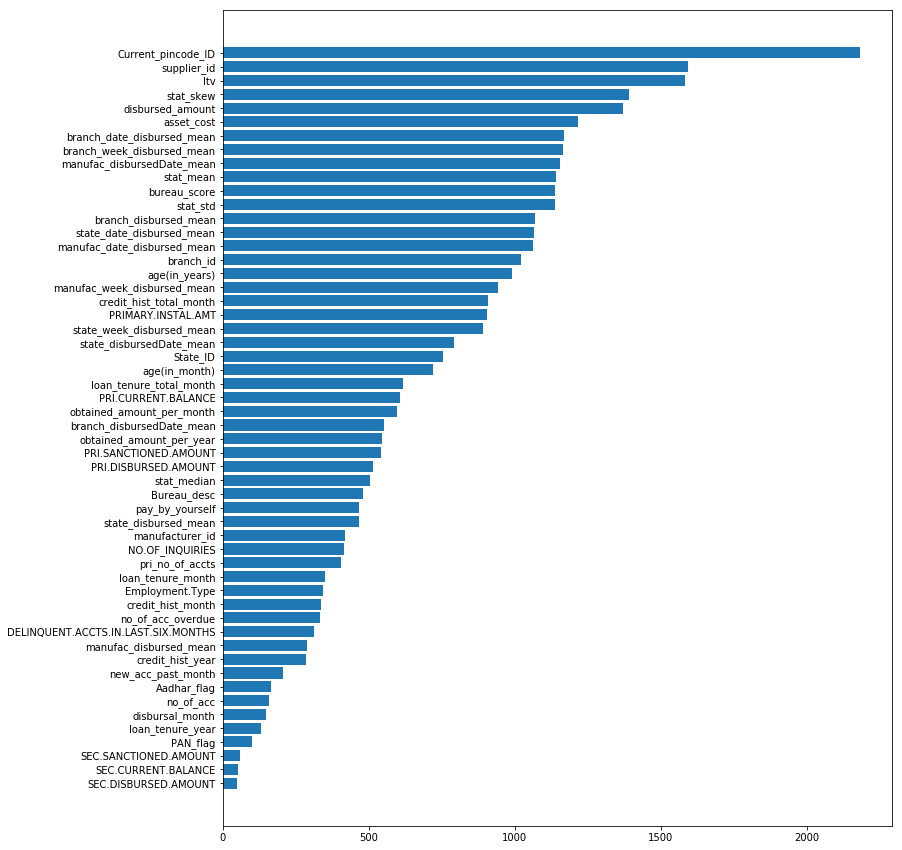

In [15]:
imp_lgb1.imp = imp_lgb1.imp.astype('float')
imp_lgb1 = imp_lgb1.groupby(['feature'])['imp'].mean()
imp_lgb1 = pd.DataFrame(data=[imp_lgb1.index, imp_lgb1.values]).T
imp_lgb1.columns=['feature','imp']
imp_lgb1 = imp_lgb1.sort_values(by='imp')
plt.figure(figsize=(12,15))
plt.barh(imp_lgb1.feature, imp_lgb1.imp)

<BarContainer object of 53 artists>

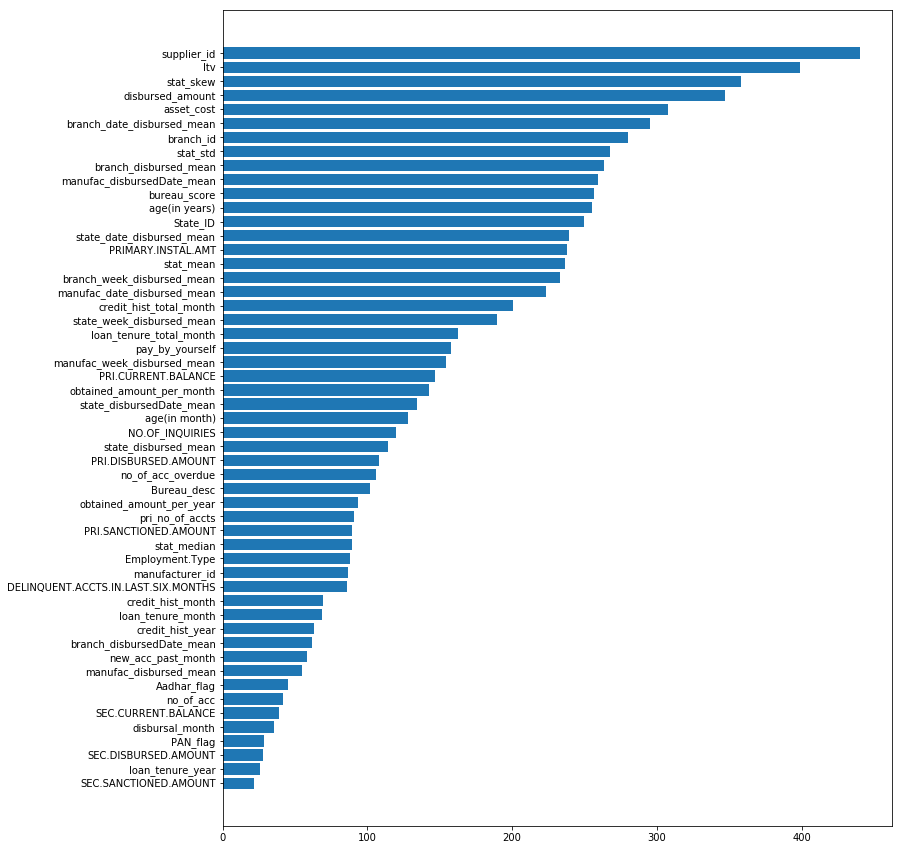

In [16]:
imp_xgb1.imp = imp_xgb1.imp.astype('float')
imp_xgb1 = imp_xgb1.groupby(['feature'])['imp'].mean()
imp_xgb1 = pd.DataFrame(data=[imp_xgb1.index, imp_xgb1.values]).T
imp_xgb1.columns=['feature','imp']
imp_xgb1 = imp_xgb1.sort_values(by='imp')
plt.figure(figsize=(12,15))
plt.barh(imp_xgb1.feature, imp_xgb1.imp)



<BarContainer object of 54 artists>

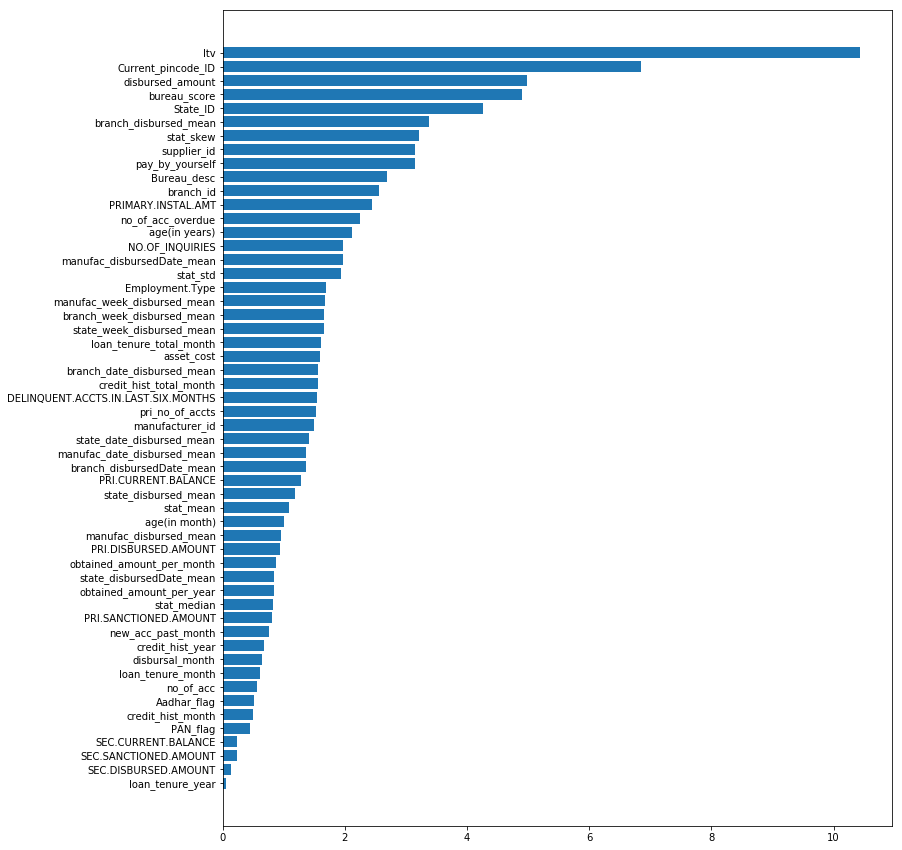

In [189]:
# imp_cat1.imp = imp_cat1.imp.astype('float')
# imp_cat1 = imp_cat1.groupby(['feature'])['imp'].mean()
# imp_cat1 = pd.DataFrame(data=[imp_cat1.index, imp_cat1.values]).T
# imp_cat1.columns=['feature','imp']
# imp_cat1 = imp_cat1.sort_values(by='imp')
# plt.figure(figsize=(12,15))
# plt.barh(imp_cat1.feature, imp_cat1.imp)

In [197]:
imp_lgb1['feature'][-25:].values

array(['loan_tenure_total_month', 'age(in_month)', 'State_ID',
       'state_disbursedDate_mean', 'state_week_disbursed_mean',
       'PRIMARY.INSTAL.AMT', 'credit_hist_total_month',
       'manufac_week_disbursed_mean', 'age(in_years)', 'branch_id',
       'manufac_date_disbursed_mean', 'state_date_disbursed_mean',
       'branch_disbursed_mean', 'stat_std', 'bureau_score', 'stat_mean',
       'manufac_disbursedDate_mean', 'branch_week_disbursed_mean',
       'branch_date_disbursed_mean', 'asset_cost', 'disbursed_amount',
       'stat_skew', 'ltv', 'supplier_id', 'Current_pincode_ID'],
      dtype=object)

In [17]:
inter_cols = ['disbursed_amount','asset_cost','supplied_id', 'age(in year)',
     'credit_hist_total_month', 'loan_tenure_total_month','PRI.CURRENT.BALANCE',
     'PRI.DISBURSED.AMOUNT','Employement.Type','manufacturer_id'
              
     'Bureau_desc', 'bureau_score', 'State_ID', 'stat_skew','stat_median','ltv'
     'stat_std', 'stat_mean', 'branch_date_disbursed_mean','PRI.SANCTIONED.AMOUNT',
     'manufac_date_disbursed_mean','Current_pincode_ID', 'pay_by_yourself',
     'no_of_acc_overdue','NO.OF_INQUIRIES', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

drop_cols = ['no_of_acc','new_acc_past_month','Aadhar_flag',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag']


In [132]:
print("lgb    : ", roc_auc_score(target, oof_lgb1))
print("xgb    : ", roc_auc_score(target, oof_xgb1))
print("cat    : ", roc_auc_score(target, oof_cat1))
print("combine: ", roc_auc_score(target, (oof_lgb1 + oof_xgb1)/2))


lgb    :  0.6694825964360887
xgb    :  0.6685872182411801
combine:  0.6698528950721344


In [18]:
complete_df = pd.concat([train_df, test_df], axis=0)
print(complete_df.shape)

int_cols = []
for col in complete_df.columns:
    n_unique = complete_df[col].unique()
    if len(n_unique) < 300:
        print(col ," ==" ,n_unique)
    else:
        print("===", col)
        int_cols.append(col)

(345546, 54)
Aadhar_flag  == [1 0]
=== Current_pincode_ID
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  == [ 0  1  2  3  5  4  7  6  8  9 12 10 20 11 18 16]
Employment.Type  == [0 1]
NO.OF_INQUIRIES  == [ 0  1  4  2  3  5  6 12  9  8 18  7 19 11 10 15 14 17 20 13 23 28 16 22
 36 21]
PAN_flag  == [0 1]
=== PRI.CURRENT.BALANCE
=== PRI.DISBURSED.AMOUNT
=== PRI.SANCTIONED.AMOUNT
=== PRIMARY.INSTAL.AMT
=== SEC.CURRENT.BALANCE
=== SEC.DISBURSED.AMOUNT
=== SEC.SANCTIONED.AMOUNT
State_ID  == [ 6  4  3  9  5 10 18 15  1 16 13 14 17  2 11  7 12  8 20 19 22 21]
=== asset_cost
branch_id  == [ 67  78  34 130  74  11   5  20  63  48  79   3  42 142  36  16 146 147
  65   9   1 152  29  10  70  19   7  85  61  17   8 153  18 162  68  72
  64   2 160 251 103 104 120 136  77  13 138 135  73 248  15 165  62  76
 105 249 250 255 254  82 158 159 117 202 259 207  35  69  97  43 257 258
 260 111  66 261 101  14 121 217  84 100]
=== disbursed_amount
=== ltv
manufacturer_id  == [ 45  86  48  51 120  49 145  67 153 156

In [19]:
int_cols.append('manufac_week_disbursed_mean')
int_cols.append('state_week_disbursed_mean')
int_cols.append('branch_disbursed_mean')
int_cols.append('manufac_disbursedDate_mean')
int_cols.append('state_disbursedDate_mean')

cat_cols = list(set(complete_df.columns) - set(int_cols))

len(int_cols), len(cat_cols)

(30, 24)

In [20]:
del complete_df
gc.collect()

44

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import RidgeClassifier, LogisticRegression

def get_standard_data(train_df, test_df, which_stdc):
    """
    Args:
        train_df, test_df
        which_stdc: which one to use ['stdc_selected', 'stdc_all']
    Return:
        standarization scaled version for numeric data
        min-max scaled version for categorical data
    """
    complete_df = pd.concat([train_df, test_df], axis=0)

    stdc = StandardScaler()
    min_max = MinMaxScaler()

    if which_stdc == 'stdc_selected':
        X1 = stdc.fit_transform(complete_df[int_cols])
        X2 = min_max.fit_transform(complete_df[cat_cols])

        X1 = pd.DataFrame(data=X1, columns=int_cols)
        X2 = pd.DataFrame(data=X2, columns=cat_cols)

        complete_df = pd.concat([X1, X2], axis=1)
        del X1, X2
    elif which_stdc == 'stdc_all':
        X1 = stdc.fit_transform(complete_df)
        complete_df = pd.DataFrame(data=X1, columns=list(complete_df.columns))
        del X1
    else:
        print("pls verify flag, it should be one of ['stdc_selected', 'stdc_all']")
        
    train_df_new = complete_df.iloc[:train_df.shape[0],:]
    test_df_new  = complete_df.iloc[train_df.shape[0]:,:]
#     print(train_df_new.shape, test_df_new.shape)
    
    test_df_new = test_df_new.reset_index(drop=True)
    
    del complete_df
    gc.collect()
    return train_df_new, test_df_new
    
# tp, ts = get_standard_data(train_df, test_df)

# def get_standard_data(train_df, test_df):
#     """
#     Args:
#         train_df, test_df
#     Return:
#         standarization scaled version for numeric data
#         min-max scaled version for categorical data
#     """
#     complete_df = pd.concat([train_df, test_df], axis=0)
#     stdc = StandardScaler()
#     X1 = stdc.fit_transform(complete_df)
#     complete_df = pd.DataFrame(data=X1, columns=list(complete_df.columns))
    
#     train_df_new = complete_df.iloc[:train_df.shape[0],:]
#     test_df_new  = complete_df.iloc[train_df.shape[0]:,:]
# #     print(train_df_new.shape, test_df_new.shape)
    
#     test_df_new = test_df_new.reset_index(drop=True)
    
#     del X1, complete_df
#     gc.collect()
#     return train_df_new, test_df_new

In [32]:

# ridge = RidgeClassifier(class_weight='balanced', alpha=10)
# ridge.fit(complete_df.iloc[:200000,:],target.iloc[:200000])

# print(roc_auc_score(target.iloc[200000:], 1+ridge.decision_function(complete_df.iloc[200000:233154,:])))
# print(ridge.score(complete_df.iloc[200000:233154,:],target.iloc[200000:]))

0.6263331325862127
0.5400253363093442


In [41]:
# logistic = LogisticRegression(class_weight='balanced', n_jobs=-1, C=.1)
# logistic.fit(complete_df.iloc[:200000,:],target.iloc[:200000])

# print(roc_auc_score(target.iloc[200000:], logistic.predict_proba(complete_df.iloc[200000:233154,:])[:,1]))
# # print(roc_auc_score(target.iloc[200000:], 1+logistic.decision_function(complete_df.iloc[200000:233154,:])))
# print(logistic.score(complete_df.iloc[200000:233154,:],target.iloc[200000:]))

0.6232597299555513
0.5385473849309284


In [95]:
# logistic = LogisticRegression(class_weight='balanced', n_jobs=-1, penalty='l1')
# logistic.fit(complete_df.iloc[:200000,:],target.iloc[:200000])

# print(roc_auc_score(target.iloc[200000:], logistic.predict_proba(complete_df.iloc[200000:233154,:])[:,1]))
# # print(roc_auc_score(target.iloc[200000:], 1+logistic.decision_function(complete_df.iloc[200000:233154,:])))
# print(logistic.score(complete_df.iloc[200000:233154,:],target.iloc[200000:]))

In [57]:
def train_ridge_model(X_train, y_train, X_valid, y_valid, X_test, alpha=None):
    """
    Args:
        alpha: regularization Strength
    Return:
        oof-pred, test_preds, model, model_imp
    """
    if alpha is None: alpha = 1
    
    clf = RidgeClassifier(class_weight='balanced', alpha=alpha, random_state=1234)
    clf.fit(X_train, y_train)
    oof = 1+clf.decision_function(X_valid)
    test_pred = clf.decision_function(X_test)

    return oof, test_pred, clf

def train_logistic_model(X_train, y_train, X_valid, y_valid, X_test, penality, C=None):
    """
    Args:
        penality: 'l1' or 'l2'
        C: regularization Strength
    Return:
        oof-pred, test_preds, model, model_imp
    """
    if C is None: C = 1
    
    if penality == 'l1':
        clf = LogisticRegression(class_weight='balanced', n_jobs=-1, verbose=1,
                                 C=C, penality='l1', random_state=1234)
    elif penality == 'l2':
        clf = LogisticRegression(class_weight='balanced', n_jobs=-1, C=C,
                                 verbose=True, random_state=1234)
    else:
        print("mismatch parameter: ")
        pass
    
    clf.fit(X_train, y_train)
    oof = clf.predict_proba(X_valid)[:,1]
    test_pred = clf.predict_proba(X_test)[:,1]

    return oof, test_pred, clf



def run_cv_linear(train_df, target, test_df, model_name, which_std,
                  penality=None, alpha=None, log_C=None):
    """
    Args:
        model_name: 'logistic', 'ridge' #LogisticRegression', 'RidgeClassifier'
        penality: 'l1' or 'l2' for logistic 
        alpha: regularization for ridge
        log_C: regularization for logistic
        which_std: flag to run standardization ['stdc_selected','stdc_all']
    """
    train_df_stdc, test_df_stdc = get_standard_data(train_df, test_df, which_std)
    
    reduce_mem_usage_wo_print(train_df_stdc)
    reduce_mem_usage_wo_print(test_df_stdc)
    ##########################
    n_splits = 3
    random_seed = 1234
    
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_linear = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df_stdc.iloc[train_index,:], train_df_stdc.iloc[valid_index,:]
                
        if log_C is None: log_C = 1
        if alpha is None: alpha = 1
        if penality is None: penality = 'l2'
            
        if model_name == 'logistic':
            oof, test_pred, clf = train_logistic_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       test_df_stdc, penality, C=log_C)
        elif model_name == 'ridge':
            oof, test_pred, clf = train_ridge_model(X_train, y_train, 
                                                    X_valid, y_valid, 
                                                    test_df_stdc, alpha=alpha)
        else:
            print("Incorrect model name")
            pass

    
        oof_linear[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        clfs.append(clf)
        
        score = roc_auc_score(y_valid, oof)
        print( "  auc = ", score )
        print("="*60)
    
    return clfs, oof_linear, predictions


In [23]:
model_logistic, oof_logistic, pred_logistic = run_cv_linear(train_df, target, 
                                                            test_df,'logistic',
                                                            'stdc_selected'
                                                           )
make_prediction("logistic1", pred_logistic, ts_unique_ids, sub)
np.save('submission/stacking/oof_logistic1.npy',oof_logistic)
del oof_logistic, pred_logistic
gc.collect()

# make_prediction("cat_stratified", pred_cat1, ts_unique_ids, sub)

Memory 96.06 MB ==>  24.01 MB
Decreased by 75.0%
Memory 46.30 MB ==>  11.58 MB
Decreased by 75.0%
(155435,) (77719,)
Fold 0
[LibLinear]  auc =  0.6390215353663637
(155436,) (77718,)
Fold 1
[LibLinear]  auc =  0.6364767967790068
(155437,) (77717,)
Fold 2
[LibLinear]  auc =  0.6365326730423747
successfully saved


21

In [24]:
model_ridge, oof_ridge, pred_ridge = run_cv_linear(train_df, target, 
                                                   test_df,'ridge', 
                                                   'stdc_selected')
make_prediction("ridge1", pred_ridge, ts_unique_ids, sub)
np.save('submission/stacking/oof_ridge1.npy',oof_ridge)
del oof_ridge, pred_ridge
gc.collect()

Memory 96.06 MB ==>  24.01 MB
Decreased by 75.0%
Memory 46.30 MB ==>  11.58 MB
Decreased by 75.0%
(155435,) (77719,)
Fold 0
  auc =  0.6388612953987687
(155436,) (77718,)
Fold 1
  auc =  0.6360989002146465
(155437,) (77717,)
Fold 2
  auc =  0.636283076575724
successfully saved


21

In [26]:
# try:
#     make_prediction("ridge1", pred_ridge, ts_unique_ids, sub)
#     np.save('submission/stacking/oof_ridge1.npy',oof_ridge)
#     del oof_ridge, pred_ridge
#     gc.collect()
# except:
#     print("could not save ridge")

In [35]:
drop_cols = ['no_of_acc',
             'Aadhar_flag',
#              'VoterID_flag',
#              'SEC.NO.OF.ACCTS',
#              'SEC.ACTIVE.ACCTS',
             'SEC.SANCTIONED.AMOUNT',
             'SEC.DISBURSED.AMOUNT',
#              'SEC.OVERDUE.ACCTS',
             'SEC.CURRENT.BALANCE',
#              'SEC.INSTAL.AMT'
            ]

train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)


In [105]:
import h2o
h2o.init()
# h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpfds4_7wq
  JVM stdout: /tmp/tmpfds4_7wq/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmpfds4_7wq/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 1 month and 15 days !!!"
H2O cluster name:,H2O_from_python_ankish_ldlnjp
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [106]:

# train = h2o.H2OFrame(pd.concat([feature_df.iloc[:target.shape[0]], target], axis=1))                     
# test  = h2o.H2OFrame(feature_df.iloc[target.shape[0]:].reset_index(drop=True))

train = h2o.H2OFrame(pd.concat([train_df, target], axis=1))                     
test  = h2o.H2OFrame(test_df)
print(train.shape, test.shape)

gc.collect()

x = train.columns
y = "loan_default"
x.remove(y)

train[y] = train[y].asfactor()
# test[y]  = test[y].asfactor()

# aml = H2OAutoML(max_models=20, seed=1337, max_runtime_secs=14400, nfolds=3)
# aml.train(x = x, y = y,
#           training_frame = train,
#           leaderboard_frame = test)
# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(233154, 58) (112392, 57)


0

In [108]:
# del train, test
gc.collect()
# train.head()

0

In [109]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
# from h2o.estimators.kmeans import H2OKMeansEstimator
# from h2o.estimators.xgboost import H2OXGBoostEstimator


In [110]:
def make_h20_prediction(file_path, df, test_ids, sub_df):
    """
    Args:
        file_path: file-name with base-path as "submission"
        df: H2o data-frame with 3 columns [predict, p0, p1]
        test_ids: test_ids
        sub_df: submission data-frame
        
    Return:
        output a file with given name
        
    Example: 
    >>> make_prediction(file_path, predictions, ts_unique_ids, sub)
    """
    sub_df = pd.DataFrame({"ID_code":test_ids})
    sub_df["target"] = df
    sub_df.columns = sub.columns

    sub_df.to_csv('submission/stacking/{}.csv'.format(file_path), index=None)
    print("successfully saved")


In [87]:
# drf_model_deep = H2ORandomForestEstimator( nfolds=3, seed=1234,
#                                            keep_cross_validation_predictions=True,
#                                            fold_assignment = 'stratified',
# #                                            histogram_type = 'QuantilesGlobal',
# #                                            categorical_encoding = 'eigen',
#                                            stopping_metric = 'auc',
#                                            ntrees = 50,
#                                            balance_classes = True
#                                            )
# drf_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
# print(drf_model_deep.accuracy())

drf Model Build progress: |███████████████████████████████████████████████| 100%
[[0.32959905740312584, 0.9802139608496003]]


In [ ]:
# drf_model_deep = H2ORandomForestEstimator( nfolds=3, seed=1234,
#                                            keep_cross_validation_predictions=True,
#                                            fold_assignment = 'stratified',
# #                                            histogram_type = 'QuantilesGlobal',
# #                                            categorical_encoding = 'eigen',
#                                            stopping_metric = 'auc',
#                                            ntrees = 50,
#                                            balance_classes = True,
#                                            categorical_encoding=''
#                                            )
# drf_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
# print(drf_model_deep.accuracy())

In [ ]:
# drf_model_deep = H2ORandomForestEstimator( nfolds=3, seed=1234,
#                                            keep_cross_validation_predictions=True,
#                                            fold_assignment = 'stratified',
# #                                            histogram_type = 'QuantilesGlobal',
# #                                            categorical_encoding = 'eigen',
#                                            stopping_metric = 'auc',
#                                            ntrees = 50,
#                                            balance_classes = True,
#                                            categorical_encoding=''
#                                            )
# drf_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
# print(drf_model_deep.accuracy())

In [94]:
# gbm_model_deep = H2OGradientBoostingEstimator(  nfolds=2, seed=1234,
#                                                 fold_assignment = 'stratified',
# #                                                 score_validation_sampling='stratified',
#                                                 ntrees = 100,
#                                                 learn_rate = 0.05,
#                                                 max_depth = 3,
#                                                 stopping_rounds = 5, 
#                                                 stopping_tolerance = 1e-3,
#                                                 stopping_metric = "AUC",
#                                                 categorical_encoding='sort_by_response',
#                                                 sample_rate = 0.8,
#                                                 col_sample_rate = 0.7,
#                                                 keep_cross_validation_predictions=True
#                                              )
# gbm_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
# print(gbm_model_deep.accuracy())


# # categorical_encoding
# # "auto", "enum", "one_hot_internal", "one_hot_explicit", "binary", "eigen", 
# # "label_encoder", 
# # "sort_by_response", "enum_limited" (default: "auto").

gbm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.3908483708196052, 0.7835422081542671]]


In [ ]:
# gbm_model_deep = H2OGradientBoostingEstimator(  nfolds=2, seed=1234,
#                                                 fold_assignment = 'stratified',
# #                                                 score_validation_sampling='stratified',
#                                                 ntrees = 100,
#                                                 learn_rate = 0.05,
#                                                 max_depth = 4,
#                                                 stopping_rounds = 5, 
#                                                 stopping_tolerance = 1e-3,
#                                                 stopping_metric = "AUC",
#                                                 sample_rate = 0.8,
#                                                 categorical_encoding='enum',
#                                                 col_sample_rate = 0.7,
#                                                 keep_cross_validation_predictions=True
#                                              )
# gbm_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
# print(gbm_model_deep.accuracy())

In [111]:
dl_model = H2ODeepLearningEstimator(epochs=10, nfolds=3, seed=1234, 
                                    score_validation_sampling='stratified',
                                    keep_cross_validation_predictions=True,
                                    balance_classes = True,
                                    fold_assignment='Stratified',
                                    l2 = 0.0001,
                                    loss = 'cross_entropy',
#                                     stopping_rounds=2,
                                    mini_batch_size = 200,
                                    rate_decay=0.1,
                                    stopping_rounds=2
                                   )
dl_model.train(x, y, training_frame=train)#, validation_frame=test)
print(dl_model.accuracy())

model_path = h2o.save_model(model=dl_model, path="submission/stacking/", force=True)
print(model_path)
# var_df = pd.DataFrame(dl_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# print(var_df.shape)
# var_df.head(10)
pred = dl_model.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("dl_model_test", pred_p1, ts_unique_ids, sub)

oof = dl_model.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("dl_model_oof", oof_p1, tr_unique_ids, sub)

del pred, pred_p1, oof, oof_p1
gc.collect()

# dl_model.varimp_plot()

deeplearning Model Build progress: |██████████████████████████████████████| 100%
[[0.21316192967355077, 0.7272912216458143]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DeepLearning_model_python_1555825372703_1
deeplearning prediction progress: |███████████████████████████████████████| 100%
successfully saved
successfully saved


651

In [145]:
# save the model
# model_path = h2o.save_model(model=dl_model, path="submission/stacking/", force=True)

print(model_path)
# /tmp/mymodel/DeepLearning_model_python_1441838096933

# load the model
# saved_model = h2o.load_model(model_path)

/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DeepLearning_model_python_1555699244015_1


In [113]:
dl_model_deep = H2ODeepLearningEstimator( nfolds=3, seed=1234,
                                          score_validation_sampling='stratified',
                                          keep_cross_validation_predictions=True,
                                          hidden=[100,10],
                                          activation='rectifier_with_dropout',
                                          fold_assignment='Stratified',
                                          epochs=500,
#                                           categorical_encoding='eigen',
                                          balance_classes = True,
                                          l2 = 0.0001,
                                          loss = 'cross_entropy',
                                          mini_batch_size = 500,
                                          rate_decay=0.1,
                                          stopping_rounds=3,
#                                           score_validation_samples=10000,
                                          stopping_metric="auc",
                                          stopping_tolerance=0.01
                                        )
dl_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
print(dl_model_deep.accuracy())

model_path = h2o.save_model(model=dl_model_deep, path="submission/stacking/", force=True)
print(model_path)

pred = dl_model_deep.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("dl_model_deep_test", pred_p1, ts_unique_ids, sub)

oof = dl_model_deep.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("dl_model_deep_oof", oof_p1, tr_unique_ids, sub)

# del dl_model_deep, pred, pred_p1, oof, oof_p1
gc.collect()

# dl_model_deep.varimp_plot()

deeplearning Model Build progress: |██████████████████████████████████████| 100%
[[0.3083463245090422, 0.712745397212898]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DeepLearning_model_python_1555825372703_66
deeplearning prediction progress: |███████████████████████████████████████| 100%
successfully saved
successfully saved


611

In [73]:
len(set(train.columns).intersection(test.columns)), len(set(train.columns))

(57, 58)

In [74]:
# test.columns

In [114]:
gbm_model = H2OGradientBoostingEstimator(nfolds=3, seed=1234,
                                         balance_classes = True,
                                         col_sample_rate = 0.7,
                                         learn_rate=0.1,
#                                          nbins = 128,
                                         fold_assignment='stratified',
                                         stopping_rounds=25,
                                         categorical_encoding='enum',
                                         keep_cross_validation_predictions=True
                                        )
gbm_model.train(x, y, training_frame=train)#, validation_frame=test)
print(gbm_model.accuracy())

# var_df = pd.DataFrame(gbm_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

model_path = h2o.save_model(model=gbm_model, path="submission/stacking/", force=True)
print(model_path)

pred = gbm_model.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("gbm_model_test", pred_p1, ts_unique_ids, sub)

oof = gbm_model.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("gbm_model_oof", oof_p1, tr_unique_ids, sub)

# del gbm_model, pred, pred_p1, oof, oof_p1
gc.collect()


# gbm_model.varimp_plot()

gbm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.21562357876437319, 0.6303493635116523]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/GBM_model_python_1555825372703_143
gbm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


467

In [ ]:
gbm_model_one_hot = H2OGradientBoostingEstimator(nfolds=3, seed=1234,
                                         balance_classes = True,
                                         col_sample_rate = 0.7,
                                         learn_rate=0.1,
                                         ntrees = 10000,
#                                          nbins = 128,one_hot_internal
# sort_by_response
                                         categorical_encoding='one_hot_explicit',
                                         fold_assignment='stratified',
                                         stopping_rounds=25,
#                                          categorical_encoding='enum',
                                         keep_cross_validation_predictions=True
                                        )
gbm_model_one_hot.train(x, y, training_frame=train)#, validation_frame=test)
try:
    print(gbm_model_one_hot.accuracy())
except:
    pass
# var_df = pd.DataFrame(gbm_model_one_hot.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

model_path = h2o.save_model(model=gbm_model_one_hot, path="submission/stacking/", force=True)
print(model_path)

pred = gbm_model_one_hot.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("gbm_model_one_hot_test", pred_p1, ts_unique_ids, sub)

oof = gbm_model_one_hot.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("gbm_model_one_hot_oof", oof_p1, tr_unique_ids, sub)

del gbm_model_one_hot, pred, pred_p1, oof, oof_p1
gc.collect()


# gbm_model_one_hot.varimp_plot()

In [115]:
gbm_model_sort = H2OGradientBoostingEstimator(nfolds=3, seed=1234,
                                         balance_classes = True,
                                         col_sample_rate = 0.7,
                                         learn_rate=0.1,
                                         ntrees = 10000,
#                                          nbins = 128,sort_internal
# sort_by_response
                                         categorical_encoding='sortbyresponse',
                                         fold_assignment='stratified',
                                         stopping_rounds=25,
#                                          categorical_encoding='enum',
                                         keep_cross_validation_predictions=True
                                        )
gbm_model_sort.train(x, y, training_frame=train)#, validation_frame=test)
try:
    print(gbm_model_sort.accuracy())
except:
    pass
# var_df = pd.DataFrame(gbm_model_sort.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

model_path = h2o.save_model(model=gbm_model_sort, path="submission/stacking/", force=True)
print(model_path)

pred = gbm_model_sort.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("gbm_model_sort_test", pred_p1, ts_unique_ids, sub)

oof = gbm_model_sort.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("gbm_model_sort_oof", oof_p1, tr_unique_ids, sub)

# del gbm_model_sort, pred, pred_p1, oof, oof_p1
gc.collect()


# gbm_model_sort.varimp_plot()

gbm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.21498253968371564, 0.6586346921061207]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/GBM_model_python_1555825372703_220
gbm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


467

In [ ]:
gbm_model_deep = H2OGradientBoostingEstimator(  nfolds=3, seed=1234,
                                                fold_assignment = 'stratified',
#                                                 score_validation_sampling='stratified',
                                                ntrees = 10000,
                                                learn_rate = 0.1,
                                                max_depth = 4,
                                                stopping_rounds = 5, 
                                                stopping_tolerance = 1e-3,
                                                stopping_metric = "AUC",
                                                sample_rate = 0.8,
                                                col_sample_rate = 0.7,
                                                keep_cross_validation_predictions=True
                                             )
gbm_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
try:
    print(gbm_model_deep.accuracy())
except:
    pass
# var_df = pd.DataFrame(gbm_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])

model_path = h2o.save_model(model=gbm_model_deep, path="submission/stacking/", force=True)
print(model_path)

pred = gbm_model_deep.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("gbm_model_deep_test", pred_p1, ts_unique_ids, sub)

oof = gbm_model_deep.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("gbm_model_deep_oof", oof_p1, tr_unique_ids, sub)

del gbm_model_deep, pred, pred_p1, oof, oof_p1
gc.collect()



# gbm_model_deep.varimp_plot()

                                                             

In [ ]:
# model = H2OGradientBoostingEstimator(distribution='bernoulli',
#                                         ntrees=100,
#                                         max_depth=4,
#                                         learn_rate=0.1

In [116]:
drf_model = H2ORandomForestEstimator(nfolds=3, seed=1234,
                                     ntrees=200,
                                     balance_classes=True,
                                     nbins_cats=512,
#                                      score_validation_sampling='stratified',
                                     keep_cross_validation_predictions=True,
                                     fold_assignment = 'stratified',
#                                      categorical_encoding='enum',
#                                      histogram_type='round_robin',
                                     max_depth = 6
                                    )
drf_model.train(x, y, training_frame=train)#, validation_frame=test)
try:
    print(drf_model.accuracy())
except:
    pass
# var_df = pd.DataFrame(drf_model.varimp(), 
#         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
model_path = h2o.save_model(model=drf_model, path="submission/stacking/", force=True)
print(model_path)

pred = drf_model.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("drf_model_test", pred_p1, ts_unique_ids, sub)

oof = drf_model.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("drf_model_oof", oof_p1, tr_unique_ids, sub)

del drf_model, pred, pred_p1, oof, oof_p1
gc.collect()


# drf_model.varimp_plot()

drf Model Build progress: |███████████████████████████████████████████████| 100%
[[0.21752919563454756, 0.6062917742540532]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DRF_model_python_1555825372703_618
drf prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


592

In [117]:
drf_model_deep = H2ORandomForestEstimator( nfolds=3, seed=1234,
                                           keep_cross_validation_predictions=True,
                                           fold_assignment = 'stratified',
#                                            histogram_type = 'QuantilesGlobal',
#                                            categorical_encoding = 'eigen',
                                           stopping_metric = 'auc',
                                           ntrees = 200,
                                           balance_classes = True
                                           )
drf_model_deep.train(x, y, training_frame=train)#, validation_frame=test)
print(drf_model_deep.accuracy())

model_path = h2o.save_model(model=drf_model_deep, path="submission/stacking/", force=True)
print(model_path)

pred = drf_model_deep.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("drf_model_deep_test", pred_p1, ts_unique_ids, sub)

oof = drf_model_deep.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("drf_model_deep_oof", oof_p1, tr_unique_ids, sub)

# del drf_model_deep, pred, pred_p1, oof, oof_p1
gc.collect()



# drf_model_deep.varimp_plot()

drf Model Build progress: |███████████████████████████████████████████████| 100%
[[0.33635598930992466, 0.9923002571144584]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DRF_model_python_1555825372703_737
drf prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


413

drf Model Build progress: |███████████████████████████████████████████████| 100%
[[0.26596483772710094, 0.9153000900858965]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/DRF_model_python_1555762466911_623
drf prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


424

In [90]:
# drf_model_sort = H2ORandomForestEstimator( nfolds=3, seed=1234,
#                                            keep_cross_validation_predictions=True,
#                                            fold_assignment = 'stratified',
# #                                            histogram_type = 'QuantilesGlobal',
#                                            categorical_encoding = 'sort_by_response',
#                                            stopping_metric = 'auc',
# #                                            ntrees = 10,
#                                            min_rows=5,
#                                            balance_classes = True
#                                            )
# drf_model_sort.train(x, y, training_frame=train)#, validation_frame=test)
# print(drf_model_sort.accuracy())

# model_path = h2o.save_model(model=drf_model_sort, path="submission/stacking/", force=True)
# print(model_path)

# pred = drf_model_sort.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("drf_model_sort_test", pred_p1, ts_unique_ids, sub)

# oof = drf_model_sort.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("drf_model_sort_oof", oof_p1, tr_unique_ids, sub)

# # del drf_model_sort, pred, pred_p1, oof, oof_p1
# gc.collect()



# # drf_model_sort.varimp_plot()

In [92]:
# drf_model_binary = H2ORandomForestEstimator( nfolds=3, seed=1234,
#                                            keep_cross_validation_predictions=True,
#                                            fold_assignment = 'stratified',
# #                                            histogram_type = 'QuantilesGlobal',
#                                            categorical_encoding = 'binary',
#                                            stopping_metric = 'auc',
#                                            ntrees = 100,
#                                            min_rows=5,
#                                            balance_classes = True
#                                            )
# drf_model_binary.train(x, y, training_frame=train)#, validation_frame=test)
# print(drf_model_binary.accuracy())

# model_path = h2o.save_model(model=drf_model_binary, path="submission/stacking/", force=True)
# print(model_path)

# pred = drf_model_binary.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("drf_model_binary_test", pred_p1, ts_unique_ids, sub)

# oof = drf_model_binary.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("drf_model_binary_oof", oof_p1, tr_unique_ids, sub)

# # del drf_model_binary, pred, pred_p1, oof, oof_p1
# gc.collect()



# # drf_model_binary.varimp_plot()

drf Model Build progress: |██ (failed)


OSError: Job with key $03017f00000132d4ffffffff$_891bedbd8165b94c53f8aef4937d441e failed with an exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_model_python_1555790712948_1028_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (219.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

stacktrace: 
water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_model_python_1555790712948_1028_cv_1.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (219.2 KB per tree x 100 > Zero  ) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:673)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:423)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:355)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:206)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1263)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [ ]:

# drf_model = H2ORandomForestEstimator()
# drf_model.train(x, y, training_frame=train, validation_frame=test)
# # var_df = pd.DataFrame(drf_model.varimp(), 
# #         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# drf_model.varimp_plot()

In [97]:
# glm_model = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
#                                           keep_cross_validation_predictions=True,
#                                           fold_assignment = 'stratified',
# #                                           interactions=x,
#                                           family="binomial")
# glm_model.train(x, y, training_frame=train)#, validation_frame=test)
# try:
#     print(glm_model.accuracy())
# except:
#     pass
# model_path = h2o.save_model(model=glm_model, path="submission/stacking/", force=True)
# print(model_path)

# pred = glm_model.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("glm_model_test", pred_p1, ts_unique_ids, sub)

# oof = glm_model.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("glm_model_oof", oof_p1, tr_unique_ids, sub)

# del glm_model, pred, pred_p1, oof, oof_p1
# gc.collect()

# # glm_model.std_coef_plot()

glm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.47796574913486817, 0.7830789949990136]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/GLM_model_python_1555787361063_712
glm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


1073

In [49]:

# glm_model_bal = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
#                                               keep_cross_validation_predictions=True,
#                                               fold_assignment = 'stratified',
#                                               family="binomial", 
#                                               lambda_search=True,
#                                               balance_classes=True)
# glm_model_bal.train(x, y, training_frame=train)#, validation_frame=test)
# try:
#     print(glm_model_bal.accuracy())
# except:
#     pass

# model_path = h2o.save_model(model=glm_model_bal, path="submission/stacking/", force=True)
# print(model_path)

# pred = glm_model_bal.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("glm_model_bal_test", pred_p1, ts_unique_ids, sub)

# oof = glm_model_bal.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("glm_model_bal_oof", oof_p1, tr_unique_ids, sub)

# del glm_model_bal, pred, pred_p1, oof, oof_p1
# gc.collect()


# # glm_model_bal.std_coef_plot()


glm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.981163576947463, 0.7829160125925354]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/GLM_model_python_1555762466911_993
glm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


635

In [118]:
inter_cols = ['ltv','disbursed_amount','asset_cost','supplied_id', 'age(in year)',
     'credit_hist_total_month', 'loan_tenure_total_month','PRI.CURRENT.BALANCE',
     'PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT','Bureau_desc']

drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
    'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
    'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
    'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

glm_model_inter = H2OGeneralizedLinearEstimator(nfolds=3, seed=1234,
                                                keep_cross_validation_predictions=True,
                                                fold_assignment = 'stratified',
                                                ignored_columns = drop_cols,
#                                                 interactions = inter_cols,
                                                family="binomial", 
                                                lambda_search=True,
                                                balance_classes=True,
                                                remove_collinear_columns = True)
glm_model_inter.train(x, y, training_frame=train)#, validation_frame=test)

print(glm_model_inter.accuracy())

model_path = h2o.save_model(model=glm_model_inter, path="submission/stacking/", force=True)
print(model_path)

pred = glm_model_inter.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("glm_model_inter_test", pred_p1, ts_unique_ids, sub)

oof = glm_model_inter.cross_validation_holdout_predictions()
oof = oof.as_data_frame()
oof_p1 = oof['p1'].values
make_h20_prediction("glm_model_inter_oof", oof_p1, tr_unique_ids, sub)

# del glm_model_inter, pred, pred_p1, oof, oof_p1
gc.collect()



# glm_model_inter.std_coef_plot()


glm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.4878581061891456, 0.7831133070845878]]
/home/ankish/kaggle_data_science/kaggle-comp/LTS-loan-pred/submission/stacking/GLM_model_python_1555825372703_962
glm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved
successfully saved


450

In [124]:
# from h2o.estimators.isolation_forest import H2OIsolationForestEstimator

# ife_model = H2OIsolationForestEstimator(nfolds=3, seed=1234,
#                                                 keep_cross_validation_predictions=True,
#                                                 fold_assignment = 'stratified',
# #                                                 ignored_columns = drop_cols,
# # #                                                 interactions = inter_cols,
# #                                                 family="binomial", 
# #                                                 lambda_search=True,
# #                                                 balance_classes=True,
# #                                                 remove_collinear_columns = True
#                                              )
# ife_model.train(x, y, training_frame=train)#, validation_frame=test)
# print(ife_model.accuracy())

all_models = [dl_model, dl_model_deep, gbm_model, gbm_model_sort,
              drf_model_deep, glm_model_inter]
for model in all_models:
    print(model.model_id, model.accuracy())
del all_models
gc.collect()

DeepLearning_model_python_1555825372703_1 [[0.21316192967355077, 0.7272912216458143]]
DeepLearning_model_python_1555825372703_66 [[0.3083463245090422, 0.712745397212898]]
GBM_model_python_1555825372703_143 [[0.21562357876437319, 0.6303493635116523]]
GBM_model_python_1555825372703_220 [[0.21498253968371564, 0.6586346921061207]]
DRF_model_python_1555825372703_737 [[0.33635598930992466, 0.9923002571144584]]
GLM_model_python_1555825372703_962 [[0.4878581061891456, 0.7831133070845878]]


3652

In [131]:
# from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator

# stack_model = H2OStackedEnsembleEstimator(#model_id="my_ensemble", 
#                                     training_frame=train, 
#                                     base_models=[dl_model, dl_model_deep, 
#                                                  gbm_model, gbm_model_sort,
#                                                  drf_model_deep, glm_model_inter],
#                                     seed=1234,
                                          
                                         
#                                          )#.model_id, drf_model.model_id])

# stack_model.train(x=x, y=y, training_frame=train)#, validation_frame=test)
# stack_model.accuracy()

In [122]:
# stack_model.accuracy(), gbm_model_deep.accuracy()

([[0.49226066201242635, 0.7835207631007832]],
 [[0.3908483708196052, 0.7835422081542671]])

In [99]:
drf_model_deep.accuracy()

[[0.33635598930992466, 0.9923002571144584]]

In [ ]:
# h2o.shutdown(prompt=False)


In [165]:
all_models = [dl_model, dl_model_deep, gbm_model, gbm_model_sort,
              drf_model_deep, glm_model_inter]
all_preds = []
for model in all_models:
    print(model.model_id, model.accuracy())
    all_preds.append(model.cross_validation_holdout_predictions().as_data_frame()['p1'])
# all_preds = np.array(all_preds)
# all_preds.shape

DeepLearning_model_python_1555825372703_1 [[0.21316192967355077, 0.7272912216458143]]
DeepLearning_model_python_1555825372703_66 [[0.3083463245090422, 0.712745397212898]]
GBM_model_python_1555825372703_143 [[0.21562357876437319, 0.6303493635116523]]
GBM_model_python_1555825372703_220 [[0.21498253968371564, 0.6586346921061207]]
DRF_model_python_1555825372703_737 [[0.33635598930992466, 0.9923002571144584]]
GLM_model_python_1555825372703_962 [[0.4878581061891456, 0.7831133070845878]]


In [166]:
oof_lgb1 = np.load('submission/stacking/oof_lgb11.npy')
all_preds.append(oof_lgb1)
all_preds = np.array(all_preds)
all_preds.shape

(7, 233154)

         dl       dld       gbm      gbmd       drf       glm       lgb
0  0.236692  0.326542  0.228217  0.217985  0.130792  0.284925  0.255868
1  0.327281  0.295939  0.211037  0.181039  0.108622  0.273208  0.220575
2  0.228276  0.296650  0.301309  0.281787  0.240172  0.329679  0.337925
3  0.329513  0.329791  0.330064  0.338029  0.212342  0.385608  0.380420
4  0.212991  0.277623  0.254776  0.226546  0.155722  0.221346  0.229429


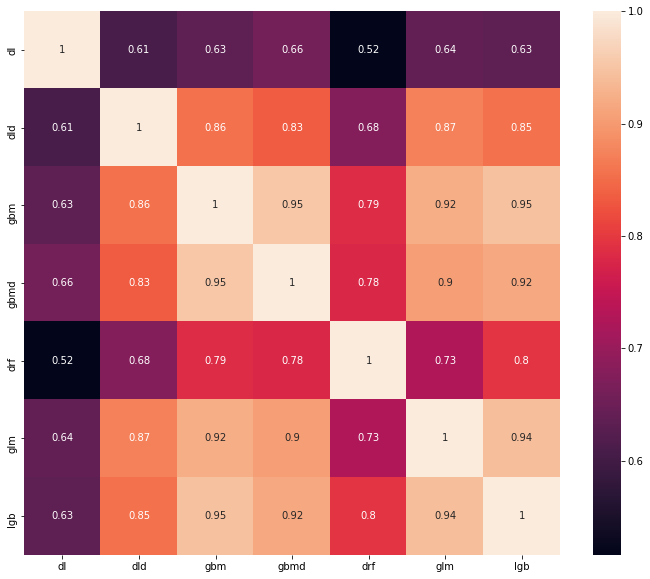

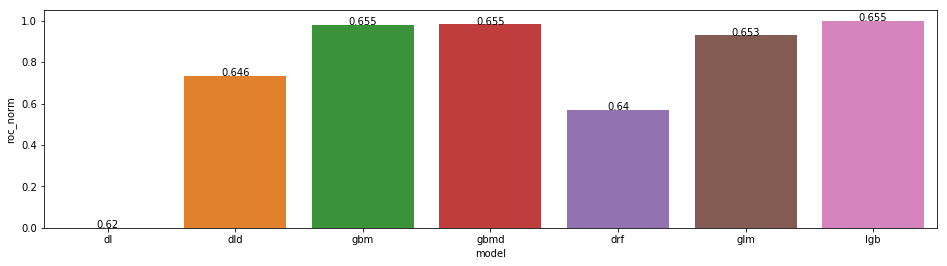

In [167]:
all_preds = pd.DataFrame(data=all_preds.T, columns = ['dl','dld','gbm',
                                                      'gbmd','drf','glm','lgb'])
print(all_preds.head())


oofs = all_preds.copy()
corr = oofs.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

roc_score = {}
for col in oofs.columns:
    roc_score[col] = roc_auc_score(target, oofs[col])
#     print(col.ljust(8), "==>", roc_auc_score(y_valid,preds[col]))
roc_score = pd.DataFrame(data=[roc_score.keys(), roc_score.values()]).T
roc_score.columns = ['model','roc']
roc_score['roc_norm'] = (roc_score.roc - roc_score.roc.min())/ \
                        (roc_score.roc.max() - roc_score.roc.min())

plt.figure(figsize=(16,4))
g = sns.barplot(x='model',y='roc_norm',data=roc_score)

for index, row in roc_score.iterrows():
    g.text(row.name,row.roc_norm, round(row.roc,3), color='black', ha="center")

    
#     # print(roc_auc_score(target, oofs1.mean(1)))
# oofs2 = oofs1.rank()
# oofs2 = oofs2/oofs2.max()
# oofs2.max()

In [191]:
oof_xgb1 = np.load('submission/stacking/saturday/oof_xgb1.npy')
oof_xgb2 = np.load('submission/stacking/saturday/oof_xgb_inter.npy')
oof_xgb3 = np.load('submission/stacking/saturday/oof_xgb_inter_3way1.npy')
oof_xgb4 = np.load('submission/stacking/saturday/oof_xgb_inter_3way2.npy')

oof_lgb1 = np.load('submission/stacking/saturday/oof_lgb1.npy')
oof_lgb2 = np.load('submission/stacking/saturday/oof_lgb_inter.npy')
oof_lgb3 = np.load('submission/stacking/saturday/oof_lgb_inter_3way1.npy')

oof_ridge = np.load('submission/stacking/saturday/oof_ridge1.npy')
oof_logistic = np.load('submission/stacking/saturday/oof_logistic1.npy')

oof_dl = pd.read_csv('submission/stacking/saturday/dl_model_oof.csv')
oof_dl_deep = pd.read_csv('submission/stacking/saturday/dl_model_deep_oof.csv')

oof_drf = pd.read_csv('submission/stacking/saturday/drf_model_oof.csv')
oof_drf_deep = pd.read_csv('submission/stacking/saturday/drf_model_deep_oof.csv')

oof_gbm = pd.read_csv('submission/stacking/saturday/gbm_model_oof.csv')
oof_gbm_deep = pd.read_csv('submission/stacking/saturday/gbm_model_deep_oof.csv')

oof_glm = pd.read_csv('submission/stacking/saturday/glm_model_oof.csv')
oof_glm_bal = pd.read_csv('submission/stacking/saturday/glm_model_inter_oof.csv')
oof_glm_inter = pd.read_csv('submission/stacking/saturday/glm_model_bal_oof.csv')


oofs_purane = np.column_stack([oof_xgb1,oof_xgb2, oof_xgb3, oof_xgb4,
                 oof_lgb1, oof_lgb2, oof_lgb3, oof_ridge, oof_logistic,
                 oof_dl.loan_default.values, oof_dl_deep.loan_default.values,
                 oof_drf.loan_default.values, oof_drf_deep.loan_default.values,
                 oof_gbm.loan_default.values, oof_gbm_deep.loan_default.values,
                 oof_glm.loan_default.values, oof_glm_bal.loan_default.values,
                 oof_glm_inter.loan_default.values])

oofs_purane = pd.DataFrame(data=oofs_purane, columns=['xgb1', 'xgb2', 'xgb3', 'xgb4',
 'lgb1', 'lgb2', 'lgb3','ridge','logistic', 'dl','dll', 'drf','drfd','gbm','gbmd',
 'glm','glmd','glmdd'])

oofs_purane.columns = [col+'_p' for col in oofs_purane.columns]
oofs_purane.head()


,xgb1_p,xgb2_p,xgb3_p,xgb4_p,lgb1_p,lgb2_p,lgb3_p,ridge_p,logistic_p,dl_p,dll_p,drf_p,drfd_p,gbm_p,gbmd_p,glm_p,glmd_p,glmdd_p
0,0.279558,0.230627,0.254008,0.263215,0.271919,0.234817,0.250638,1.108753,0.557156,0.245364,0.310234,0.256820,0.203082,0.269859,0.284489,0.260158,0.259406,0.259406
1,0.318999,0.217544,0.241636,0.216195,0.321177,0.223319,0.235175,1.297361,0.656786,0.335284,0.311298,0.236017,0.205469,0.302504,0.342944,0.350064,0.346350,0.346350
2,0.337744,0.336892,0.342341,0.371819,0.330587,0.296813,0.317296,1.194615,0.601275,0.274574,0.332132,0.260883,0.306863,0.292085,0.340802,0.303453,0.300330,0.300330
3,0.401604,0.405946,0.386319,0.425901,0.448191,0.396828,0.413421,1.386607,0.696288,0.516946,0.394033,0.285780,0.351303,0.371664,0.444996,0.356607,0.347315,0.347315
4,0.277607,0.207844,0.227148,0.212794,0.293714,0.179690,0.252171,1.198796,0.605304,0.316194,0.319963,0.262044,0.288951,0.293183,0.293055,0.301754,0.305987,0.305987


In [198]:
pred_all = pd.concat([oofs, oofs_purane], axis=1)
oofs1 = oofs.copy()
oofs = pred_all.copy()
oofs.shape, pred_all.shape

((233154, 25), (233154, 25))

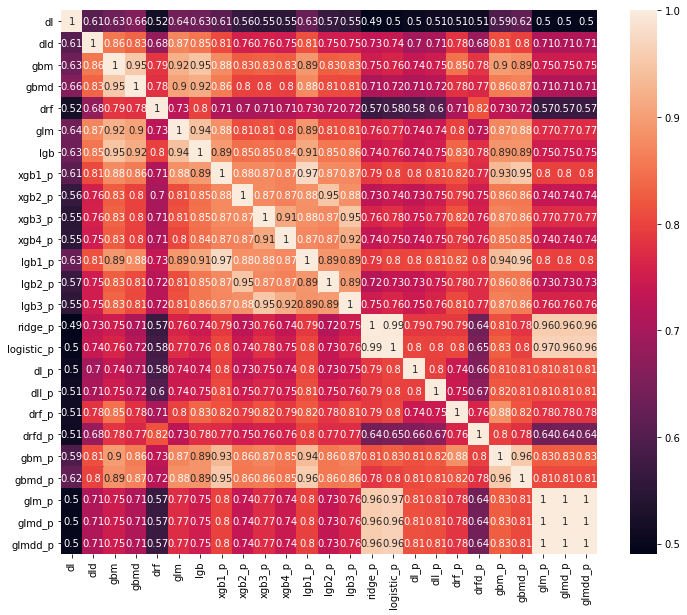

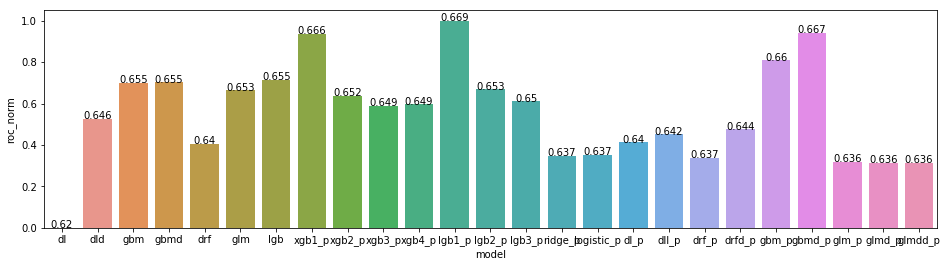

In [199]:
corr = oofs.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

roc_score = {}
for col in oofs.columns:
    roc_score[col] = roc_auc_score(target, oofs[col])
#     print(col.ljust(8), "==>", roc_auc_score(y_valid,preds[col]))
roc_score = pd.DataFrame(data=[roc_score.keys(), roc_score.values()]).T
roc_score.columns = ['model','roc']
roc_score['roc_norm'] = (roc_score.roc - roc_score.roc.min())/ \
                        (roc_score.roc.max() - roc_score.roc.min())

plt.figure(figsize=(16,4))
g = sns.barplot(x='model',y='roc_norm',data=roc_score)

for index, row in roc_score.iterrows():
    g.text(row.name,row.roc_norm, round(row.roc,3), color='black', ha="center")


In [151]:
print(roc_auc_score(target, oofs.mean(axis=1)))
oofs1 = oofs.rank()
oofs1 = oofs1/oofs1.max()
print(roc_auc_score(target, oofs1.mean(axis=1)))

0.6569062132786131
0.6575982071986435


In [152]:
nested_list = [['a','b',1],['c','d',3],['a','f',8],['a','c',5]]
from collections import defaultdict
from itertools import combinations

d = defaultdict(list)    

for i, j, _ in nested_list:
    d[i].append(j)
     

{k: list(combinations(v, 2)) for k, v in d.items()}
# {'a': [('b', 'f'), ('b', 'c'), ('f', 'c')], 'c': []}

{'a': [('b', 'f'), ('b', 'c'), ('f', 'c')], 'c': []}

In [205]:
# a = ['a','b','c','d']
# for cur_comb in [list(combinations(a,2)) + list(combinations(a,3))]:
#     print(cur_comb)



In [206]:
oofs1 = all_preds.copy()

mean_score = []
rank_score = []
count = 0
for r in range(2, oofs1.shape[1]):
    for cur_comb in list(combinations(oofs1.columns, r)):
#         print(list(cur_comb), "==>" end=" ")
#         score = roc_auc_score(target, oofs[list(cur_comb)].mean(axis=1))
#         mean_score.append(score)
# #         print("mean: ", np.round(score,4), end=" ")
#         oofs1 = oofs[list(cur_comb)].rank()
#         oofs1 = oofs1/oofs1.max()
#         score = roc_auc_score(target, oofs1.mean(axis=1))
#         rank_score.append(score)
# #         print(" rank_avg: ",np.round(score,4))
        count += 1
    print("==>", end=" ")
print("total combinations: ", count)

==> ==> ==> ==> ==> total combinations:  119


In [ ]:
# mean_score = []
# rank_score = []
# count = 0
# for r in range(2, oofs.shape[1]):
#     for cur_comb in list(combinations(oofs.columns, r)):
# #         print(list(cur_comb), "==>" end=" ")
#         score = roc_auc_score(target, oofs[list(cur_comb)].mean(axis=1))
#         mean_score.append(score)
# #         print("mean: ", np.round(score,4), end=" ")
#         oofs1 = oofs[list(cur_comb)].rank()
#         oofs1 = oofs1/oofs1.max()
#         score = roc_auc_score(target, oofs1.mean(axis=1))
#         rank_score.append(score)
# #         print(" rank_avg: ",np.round(score,4))
#         count += 1
#     print("==>", end=" ")

    
def scoring(r)   
    mean_score = []
    rank_score = []
    count = 0
    for r in range(2, oofs1.shape[1]):
        for cur_comb in list(combinations(oofs1.columns, r)):
    #         print(list(cur_comb), "==>" end=" ")
            score = roc_auc_score(target, oofs1[list(cur_comb)].mean(axis=1))
            mean_score.append(score)
    #         print("mean: ", np.round(score,4), end=" ")
            oofs_ = oofs1[list(cur_comb)].rank()
            oofs_ = oofs_/oofs_.max()
            score = roc_auc_score(target, oofs_.mean(axis=1))
            rank_score.append(score)
    #         print(" rank_avg: ",np.round(score,4))
            count += 1
#         print("==>", end=" ")
    return (mean_score, rank_score)


In [210]:
%%time

import multiprocessing as mp

def scoring(r):   
    mean_score = []
    rank_score = []
#     for r in range(2, oofs1.shape[1]):
    for cur_comb in list(combinations(oofs1.columns, r)):
#         print(list(cur_comb), "==>" end=" ")
        score = roc_auc_score(target, oofs1[list(cur_comb)].mean(axis=1))
        mean_score.append(score)
#         print("mean: ", np.round(score,4), end=" ")
        oofs_ = oofs1[list(cur_comb)].rank()
        oofs_ = oofs_/oofs_.max()
        score = roc_auc_score(target, oofs_.mean(axis=1))
        rank_score.append(score)
#         print(" rank_avg: ",np.round(score,4))
#         print("==>", end=" ")
    return (mean_score, rank_score)

pool = mp.Pool(mp.cpu_count())
results = pool.map(scoring, [r for r in np.arange(2, oofs1.shape[1])])
pool.close()

CPU times: user 20 ms, sys: 84 ms, total: 104 ms
Wall time: 14.2 s


In [211]:
%%time

mean_score = []
rank_score = []
for r in range(2, oofs1.shape[1]):
    for cur_comb in list(combinations(oofs1.columns, r)):
#         print(list(cur_comb), "==>" end=" ")
        score = roc_auc_score(target, oofs1[list(cur_comb)].mean(axis=1))
        mean_score.append(score)
#         print("mean: ", np.round(score,4), end=" ")
        oofs_ = oofs1[list(cur_comb)].rank()
        oofs_ = oofs_/oofs_.max()
        score = roc_auc_score(target, oofs_.mean(axis=1))
        rank_score.append(score)

CPU times: user 31.9 s, sys: 48 ms, total: 32 s
Wall time: 31.6 s


In [215]:
gc.collect()

76801

In [216]:
%%time

import multiprocessing as mp

def get_score(r):   
    mean_score = []
    rank_score = []
#     for r in range(2, oofs1.shape[1]):
    for cur_comb in list(combinations(oofs.columns, r)):
#         print(list(cur_comb), "==>" end=" ")
        score = roc_auc_score(target, oofs[list(cur_comb)].mean(axis=1))
        mean_score.append(score)
#         print("mean: ", np.round(score,4), end=" ")
        oofs_ = oofs[list(cur_comb)].rank()
        oofs_ = oofs_/oofs_.max()
        score = roc_auc_score(target, oofs_.mean(axis=1))
        rank_score.append(score)
#         print(" rank_avg: ",np.round(score,4))
#         print("==>", end=" ")
    return (mean_score, rank_score)

pool = mp.Pool(mp.cpu_count())
results = pool.map(get_score, [r for r in np.arange(2, oofs.shape[1])])
pool.close()
gc.collect()

KeyboardInterrupt: 

Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<timed exec>", line 10, in get_score
  File "/home/ankish/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ankish/anaconda3/l

In [221]:
gc.collect()

0

In [200]:
mean_score = []
rank_score = []
count = 0
for r in range(2, oofs.shape[1]):
    for cur_comb in list(combinations(oofs.columns, r)):
#         print(list(cur_comb), "==>" end=" ")
        score = roc_auc_score(target, oofs[list(cur_comb)].mean(axis=1))
        mean_score.append(score)
#         print("mean: ", np.round(score,4), end=" ")
        oofs1 = oofs[list(cur_comb)].rank()
        oofs1 = oofs1/oofs1.max()
        score = roc_auc_score(target, oofs1.mean(axis=1))
        rank_score.append(score)
#         print(" rank_avg: ",np.round(score,4))
        count += 1
    print("==>", end=" ")
    

KeyboardInterrupt: 

Text(0.5, 1.0, 'rank_score')

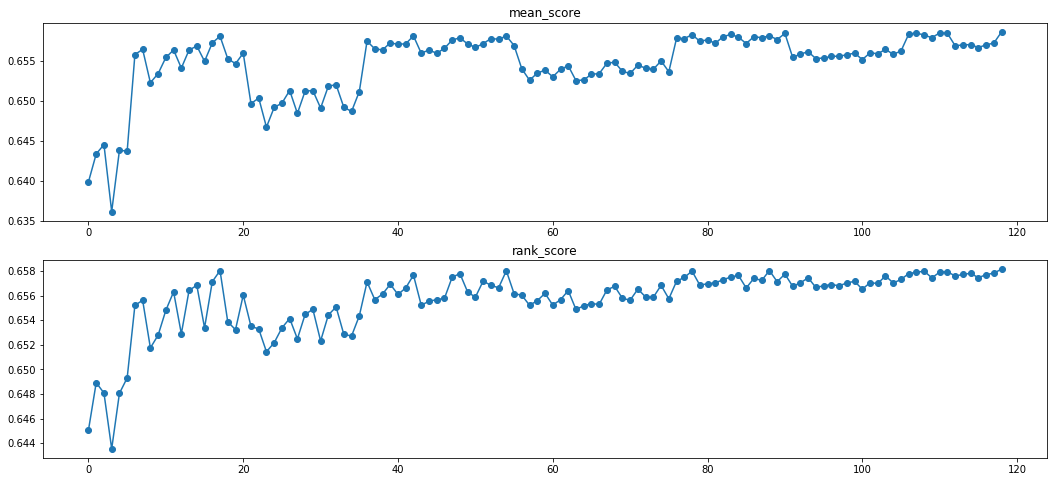

In [181]:
fig, ax = plt.subplots(2,1,figsize=(18,8))
ax[0].plot(mean_score, '-o')
ax[0].set_title("mean_score")

ax[1].plot(rank_score, '-o')
ax[1].set_title("rank_score")


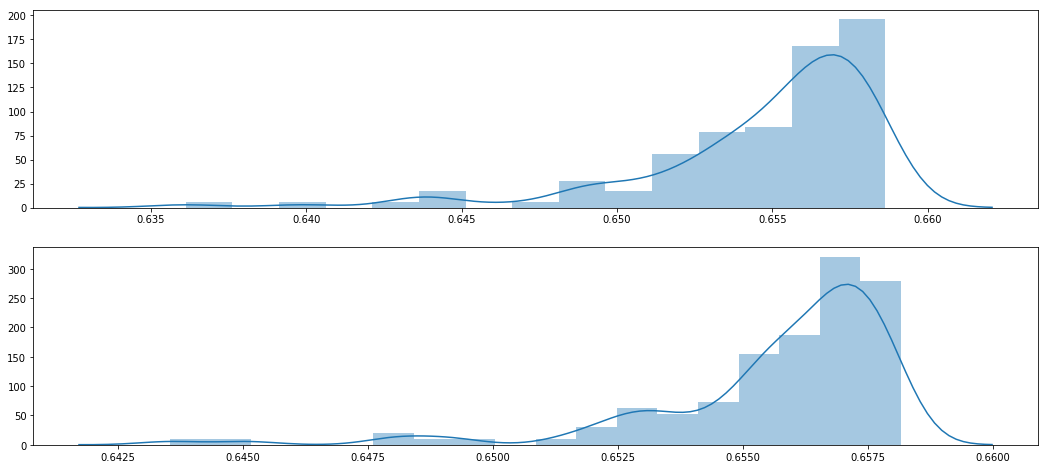

In [182]:
fig, ax = plt.subplots(2,1,figsize=(18,8))
sns.distplot(mean_score, ax=ax[0])
sns.distplot(rank_score, ax=ax[1])


In [ ]:
fig, ax = plt.subplots(2,1,figsize=(18,8))
ax[0].plot(mean_score, '-o')
ax[0].set_title("mean_score")

ax[1].plot(rank_score, '-o')
ax[1].set_title("rank_score")


In [34]:
# train_df, test_df = get_standard_data(train_df, test_df)


In [35]:
# model_lgb2, imp_lgb2, oof_lgb2, pred_lgb2 = run_cv_lgb(train_df, target, test_df)
# make_prediction("lgb2", pred_lgb2, ts_unique_ids, sub)
# np.save('submission/stacking/oof_lgb2.npy',oof_lgb2)
# del oof_lgb2, pred_lgb2
# gc.collect()

(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.666523	valid_1's auc: 0.656531
[400]	training's auc: 0.678279	valid_1's auc: 0.663875
[600]	training's auc: 0.686696	valid_1's auc: 0.66725
[800]	training's auc: 0.69374	valid_1's auc: 0.668938
[1000]	training's auc: 0.699933	valid_1's auc: 0.67001
[1200]	training's auc: 0.705758	valid_1's auc: 0.670534
[1400]	training's auc: 0.710932	valid_1's auc: 0.671142
Early stopping, best iteration is:
[1419]	training's auc: 0.711459	valid_1's auc: 0.671214
  auc =  0.6712135185679058
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.668823	valid_1's auc: 0.652636
[400]	training's auc: 0.680168	valid_1's auc: 0.659424
[600]	training's auc: 0.688797	valid_1's auc: 0.663192
[800]	training's auc: 0.695427	valid_1's auc: 0.665093
[1000]	training's auc: 0.701301	valid_1's auc: 0.666078
[1200]	training's auc: 0.706741	valid_1's au

185

In [36]:
# model_xgb2, imp_xgb2, oof_xgb2, pred_xgb2 = run_cv_xgb(train_df, target, test_df, 4)
# make_prediction("xgb2", pred_xgb2, ts_unique_ids, sub)
# np.save('submission/stacking/oof_xgb2.npy',oof_xgb2)
# del oof_xgb2, pred_xgb2
# gc.collect()


(155435,) (77719,)
Fold 0
[0]	valid-auc:0.564335
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.664854
[400]	valid-auc:0.668592
[600]	valid-auc:0.669563
Stopping. Best iteration:
[685]	valid-auc:0.669924

  auc =  0.6699236719182279
(155436,) (77718,)
Fold 1
[0]	valid-auc:0.598111
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.660289
[400]	valid-auc:0.66414
[600]	valid-auc:0.665282
[800]	valid-auc:0.666207
Stopping. Best iteration:
[796]	valid-auc:0.66623

  auc =  0.6662299371802843
(155437,) (77717,)
Fold 2
[0]	valid-auc:0.605941
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.665013
[400]	valid-auc:0.668584
Stopping. Best iteration:
[424]	valid-auc:0.668751

  auc =  0.6687506505793744
successfully saved


63

In [37]:

# model_cat2, imp_cat2, oof_cat2, pred_cat2 = run_cv_cat(train_df, target, test_df, 4)
# make_prediction("cat2", pred_cat2, ts_unique_ids, sub)
# np.save('submission/stacking/oof_cat2.npy',oof_cat2)
# del oof_cat2, pred_cat2
# gc.collect()

(155435,) (77719,)
Fold 0
0:	test: 0.5966345	test1: 0.5988838	best: 0.5988838 (0)	total: 109ms	remaining: 18m 9s
200:	test: 0.6677184	test1: 0.6630408	best: 0.6630408 (200)	total: 23.7s	remaining: 19m 16s
400:	test: 0.6800048	test1: 0.6674044	best: 0.6674167 (399)	total: 46.7s	remaining: 18m 38s
600:	test: 0.6879741	test1: 0.6684867	best: 0.6684903 (598)	total: 1m 10s	remaining: 18m 17s
800:	test: 0.6949260	test1: 0.6691527	best: 0.6691527 (800)	total: 1m 33s	remaining: 17m 49s
1000:	test: 0.7013505	test1: 0.6699133	best: 0.6699133 (1000)	total: 1m 57s	remaining: 17m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6702219424
bestIteration = 1117

Shrink model to first 1118 iterations.
  auc =  0.6702219423836938
(155436,) (77718,)
Fold 1
0:	test: 0.5972136	test1: 0.5962652	best: 0.5962652 (0)	total: 87.8ms	remaining: 14m 37s
200:	test: 0.6703817	test1: 0.6575686	best: 0.6575686 (200)	total: 22.3s	remaining: 18m 5s
400:	test: 0.6819193	test1: 0.6620067	best: 0.66

35

In [22]:
# train = h2o.H2OFrame(pd.concat([train_df, target], axis=1))                     
# test  = h2o.H2OFrame(test_df)
# print(train.shape, test.shape)

# gc.collect()

# x = train.columns
# y = "loan_default"
# x.remove(y)

# train[y] = train[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(233154, 55) (112392, 54)


In [54]:
# from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# low_rank = H2OGeneralizedLowRankEstimator(k=5,#gamma_x=0.1, gamma_y=0.1,
#                                           regularization_x='l2',
#                                           regularization_y='l1',
#                                           seed=1234,
#                                           svd_method = "GramSVD",
#                                           max_iterations=5000
#                                           )
# low_rank.train(x, training_frame=train)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


In [23]:
# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator

# pca_model = H2OPrincipalComponentAnalysisEstimator(k=3,
#                                                    seed=1234,
#                                                    max_iterations=5000,
#                                                    transform='standardize',
#                                                    ignored_columns = drop_cols
#                                                    )
# pca_model.train(x, training_frame=train)

pca Model Build progress: |███████████████████████████████████████████████| 100%


In [24]:
# pca_train = pca_model.predict(train)
# pca_test  = pca_model.predict(test)

# pca_train = pca_train.as_data_frame()
# pca_test  = pca_test.as_data_frame()

# pca_train.shape, pca_test.shape


pca prediction progress: |████████████████████████████████████████████████| 100%
pca prediction progress: |████████████████████████████████████████████████| 100%


((233154, 3), (112392, 3))

In [ ]:
# from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

# low_rank = H2OGeneralizedLowRankEstimator(k=5,#gamma_x=0.1, gamma_y=0.1,
#                                           regularization_x='l2',
#                                           regularization_y='l1',
#                                           seed=1234
#                                    )
# dl_model.train(x, y, training_frame=train)#, validation_frame=test)
# model_path = h2o.save_model(model=dl_model, path="submission/stacking/", force=True)
# print(model_path)
# # var_df = pd.DataFrame(dl_model.varimp(), 
# #         columns=["Variable", "Relative Importance", "Scaled Importance", "Percentage"])
# # print(var_df.shape)
# # var_df.head(10)
# pred = dl_model.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("dl_model_test", pred_p1, ts_unique_ids, sub)

# oof = dl_model.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("dl_model_oof", oof_p1, tr_unique_ids, sub)

# del pred, pred_p1, oof, oof_p1
# gc.collect()

# # dl_model.varimp_plot()

In [25]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=5, weights='distance',
#                            algorithm='auto', leaf_size=30, 
#                            n_jobs=-1)
# knn.fit(pca_train.iloc[:-10000,:], target[:-10000])
# # knn.score(pca_train.iloc[-10000:,:], target[-10000:])
# roc_auc_score(target[-10000:], knn.predict_proba(pca_train.iloc[-10000:,:])[:,1])

0.5174773130713206

In [26]:
# from sklearn.neighbors import KDTree
# import numpy as np
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# kdt = KDTree(X, leaf_size=30, metric='euclidean')
# kdt.query(X, k=2, return_distance=False)

# # pca_all = pd.concat([pca_train, pca_test], axis=0).reset_index(drop=True)

# # kdt = KDTree(pca_all, leaf_size=30, metric='euclidean')
# # nn = kdt.query(pca_all, 
# #           k=2, return_distance=False)

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

In [52]:
gc.collect()

0

In [54]:
import glob

int_feat_2way = glob.glob('store_data/new_feat/int_inter_2way_new/*')
feature_df = pd.DataFrame()

for file in int_feat_2way:
    print(file)
    feat_df = pd.read_csv(file)
    reduce_mem_usage_wo_print(feat_df)
    feature_df = pd.concat([feature_df, feat_df], axis=1)
    gc.collect()
feature_df.shape


store_data/new_feat/int_inter_2way_new/cat_inter_2way_0.csv
Memory 263.63 MB ==>  65.91 MB
Decreased by 75.0%
store_data/new_feat/int_inter_2way_new/cat_inter_2way_2.csv
Memory 76.45 MB ==>  19.77 MB
Decreased by 74.1%
store_data/new_feat/int_inter_2way_new/cat_inter_2way_1.csv
Memory 263.63 MB ==>  67.88 MB
Decreased by 74.2%


(345546, 229)

In [55]:
# del train, test
gc.collect()


0

In [78]:
# model_xgb1, imp_xgb1, oof_xgb1, pred_xgb1 = run_cv_xgb(#train_df, target, test_df, 4)
#     pd.concat([train_df, feature_df.iloc[:target.shape[0]]], axis=1), target, 
#     pd.concat([test_df, feature_df.iloc[target.shape[0]:].reset_index(drop=True)], 
#               axis=1),
#     5)

(155435,) (77719,)
Fold 0
[0]	valid-auc:0.611914
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.666363
Stopping. Best iteration:
[327]	valid-auc:0.667877

  auc =  0.6678770170946373
(155436,) (77718,)
Fold 1
[0]	valid-auc:0.609265
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.661427
[400]	valid-auc:0.663926
Stopping. Best iteration:
[382]	valid-auc:0.66401

  auc =  0.6640098293262378
(155437,) (77717,)
Fold 2
[0]	valid-auc:0.614679
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.665837
Stopping. Best iteration:
[340]	valid-auc:0.667318

  auc =  0.6673181260636926


In [56]:
gc.collect()

0

In [57]:
model_xgb2, imp_xgb2, oof_xgb2, pred_xgb2 = run_cv_xgb(#train_df, target, test_df, 4)
    feature_df.iloc[:target.shape[0]], target, 
    feature_df.iloc[target.shape[0]:].reset_index(drop=True), 6)

make_prediction("xgb_inter", pred_xgb2, ts_unique_ids, sub)
np.save('submission/stacking/oof_xgb_inter.npy',oof_xgb2)
del oof_xgb2, pred_xgb2
gc.collect()

(155435,) (77719,)
Fold 0
[0]	valid-auc:0.61104
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.652467
Stopping. Best iteration:
[268]	valid-auc:0.653336

  auc =  0.6533361822538455
(155436,) (77718,)
Fold 1
[0]	valid-auc:0.601657
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.648073
Stopping. Best iteration:
[286]	valid-auc:0.648777

  auc =  0.6487767935174568
(155437,) (77717,)
Fold 2
[0]	valid-auc:0.60338
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.65099
Stopping. Best iteration:
[336]	valid-auc:0.652667

  auc =  0.6526669124494859
successfully saved


70

In [97]:
# imp = pd.DataFrame(data=[list(model_xgb2[2].get_fscore().keys()), 
#                    list(model_xgb2[2].get_fscore().values())]).T

# imp.columns = ['feat','imp']
# imp.sort_values(by='imp', ascending=False).head(50)


,feat,imp
60,branch_id/supplier_id_pre,216
49,pay_by_yourself/supplier_id_pre,214
2,bureau_score/manufac_disbursedDate_mean_pre,213
34,bureau_score/ltv_pre,188
24,State_ID/supplier_id_pre,174
23,manufac_date_disbursed_mean+ltv,173
101,state_disbursedDate_mean/branch_disbursed_mean...,156
58,State_ID/ltv_pre,155
29,branch_id/age(in month)_post,148
66,age(in month)/disbursed_amount_pre,141


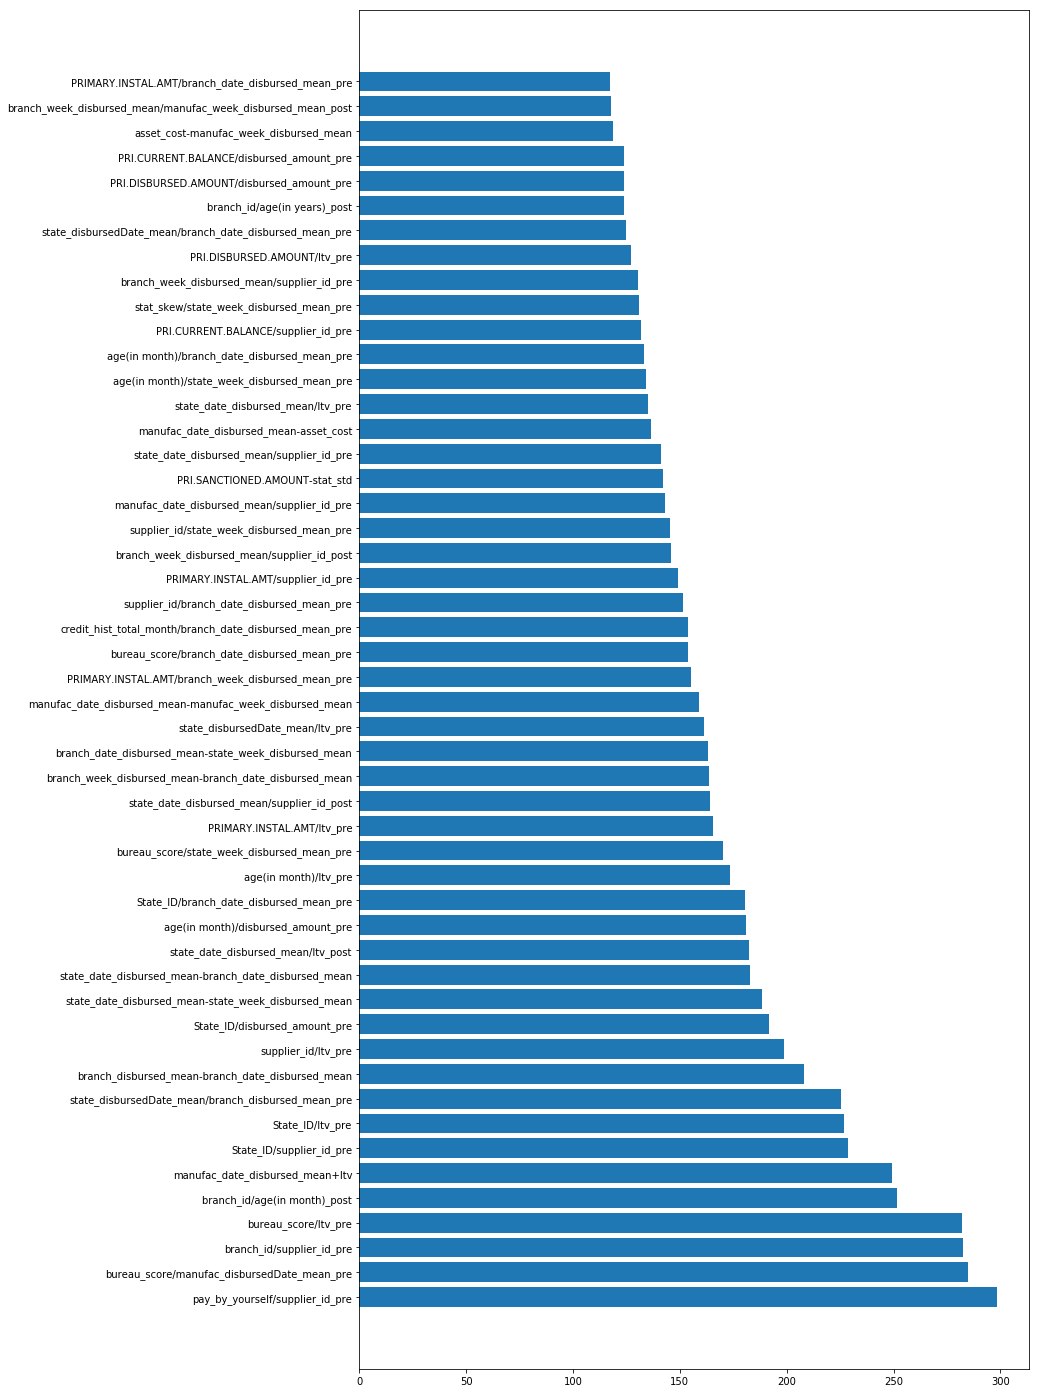

In [58]:
try:
    imp_xgb2.imp = imp_xgb2.imp.astype('float')
    imp_xgb2 = imp_xgb2.groupby(['feature'])['imp'].mean()
    imp_xgb2 = pd.DataFrame(data=[imp_xgb2.index, imp_xgb2.values]).T
    imp_xgb2.columns=['feature','imp']
    imp_xgb2 = imp_xgb2.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,25))
    plt.barh(imp_xgb2.feature, imp_xgb2.imp)
except:
    pass


In [59]:
model_lgb2, imp_lgb2, oof_lgb2, pred_lgb2 = run_cv_lgb(#train_df, target, test_df)
    feature_df.iloc[:target.shape[0]], target, 
    feature_df.iloc[target.shape[0]:].reset_index(drop=True), 120)
make_prediction("lgb_inter", pred_lgb2, ts_unique_ids, sub)
np.save('submission/stacking/oof_lgb_inter.npy',oof_lgb2)
del oof_lgb2, pred_lgb2
gc.collect()

using leaves:  120
(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.696435	valid_1's auc: 0.646766
[400]	training's auc: 0.728668	valid_1's auc: 0.652225
Early stopping, best iteration is:
[570]	training's auc: 0.753792	valid_1's auc: 0.654349
  auc =  0.6543493332680075
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.698263	valid_1's auc: 0.644015
[400]	training's auc: 0.728595	valid_1's auc: 0.648551
[600]	training's auc: 0.757075	valid_1's auc: 0.650113
Early stopping, best iteration is:
[655]	training's auc: 0.764214	valid_1's auc: 0.65056
  auc =  0.6505596320277831
(155437,) (77717,)
Fold 2
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.695828	valid_1's auc: 0.646425
[400]	training's auc: 0.727366	valid_1's auc: 0.651661
[600]	training's auc: 0.75701	valid_1's auc: 0.654056
Early stopping, best iteration is:
[641]	tr

7451

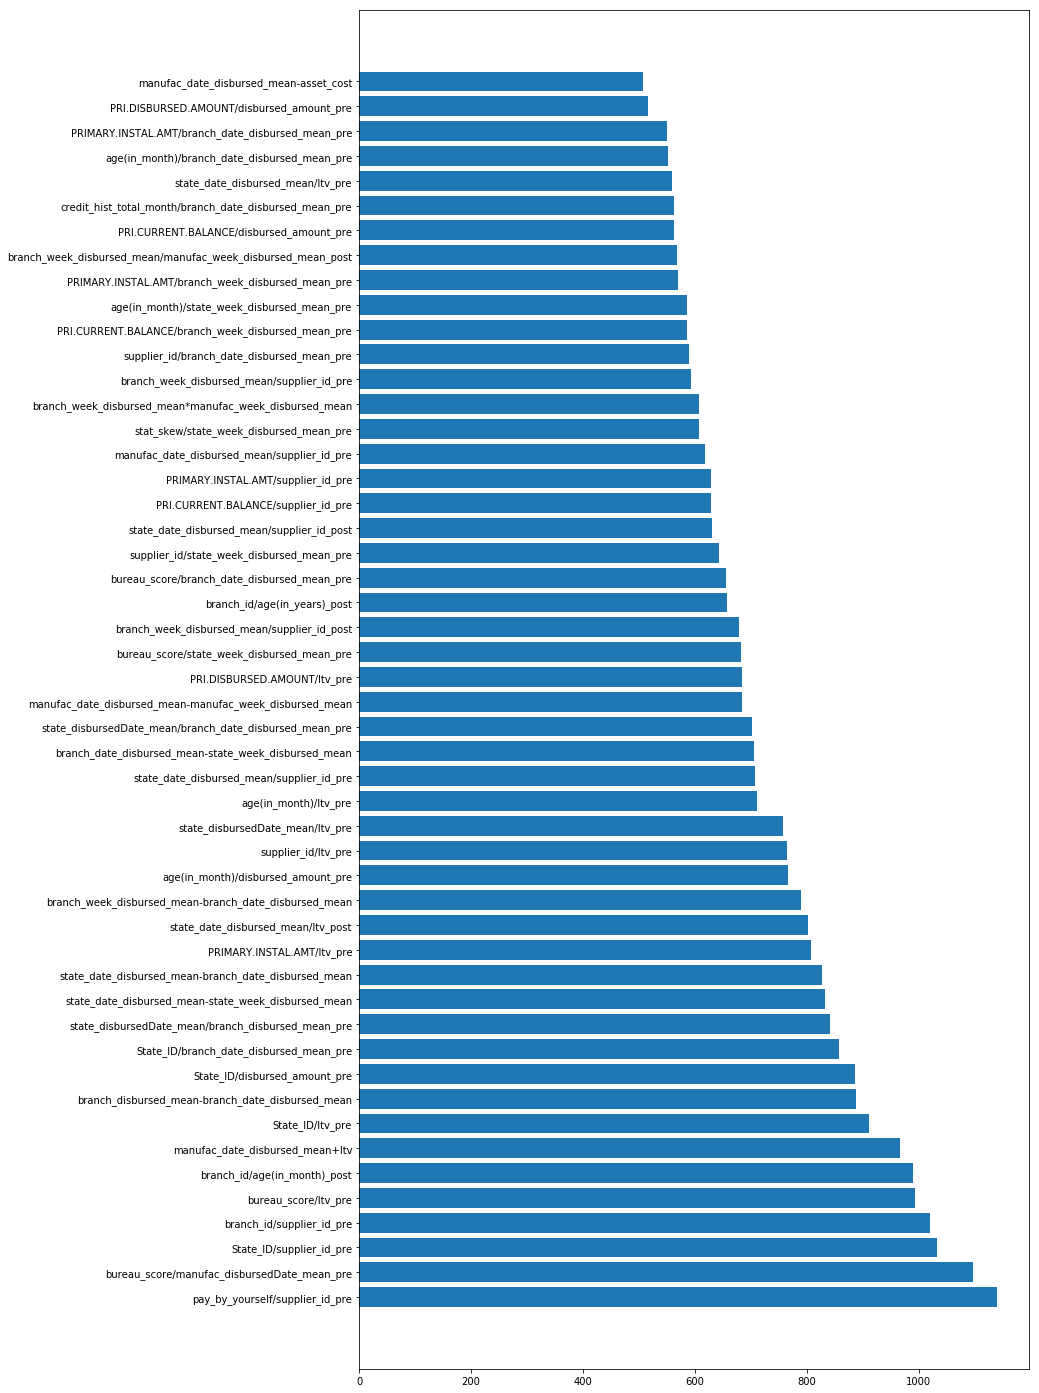

In [60]:
try:
    imp_lgb2.imp = imp_lgb2.imp.astype('float')
    imp_lgb2 = imp_lgb2.groupby(['feature'])['imp'].mean()
    imp_lgb2 = pd.DataFrame(data=[imp_lgb2.index, imp_lgb2.values]).T
    imp_lgb2.columns=['feature','imp']
    imp_lgb2 = imp_lgb2.sort_values(by='imp', ascending=False).head(50)
    plt.figure(figsize=(12,25))
    plt.barh(imp_lgb2.feature, imp_lgb2.imp)
except:
    pass


In [61]:
del feature_df
gc.collect()

7351

In [62]:
import glob

int_feat_3way = glob.glob('store_data/new_feat/int_inter_3way_new/*')
feature_df = pd.DataFrame()

for file in int_feat_3way[:2]:
    print(file)
    feat_df = pd.read_csv(file)
    reduce_mem_usage_wo_print(feat_df)
    feature_df = pd.concat([feature_df, feat_df], axis=1)
    gc.collect()

feature_df.shape


store_data/new_feat/int_inter_3way_new/cat_inter_3way_2.csv
Memory 263.63 MB ==>  69.20 MB
Decreased by 73.7%
store_data/new_feat/int_inter_3way_new/cat_inter_3way_0.csv
Memory 263.63 MB ==>  71.84 MB
Decreased by 72.7%


(345546, 200)

In [63]:
model_xgb3, imp_xgb3, oof_xgb3, pred_xgb3 = run_cv_xgb(#train_df, target, test_df, 4)
    feature_df.iloc[:target.shape[0]], target, 
    feature_df.iloc[target.shape[0]:].reset_index(drop=True), 6)

make_prediction("xgb_inter_3way1", pred_xgb3, ts_unique_ids, sub)
np.save('submission/stacking/oof_xgb_inter_3way1.npy',oof_xgb3)
del oof_xgb3, pred_xgb3
gc.collect()

(155435,) (77719,)
Fold 0
[0]	valid-auc:0.61212
Will train until valid-auc hasn't improved in 25 rounds.
Stopping. Best iteration:
[172]	valid-auc:0.651331

  auc =  0.651330846229902
(155436,) (77718,)
Fold 1
[0]	valid-auc:0.605157
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.645895
Stopping. Best iteration:
[263]	valid-auc:0.64646

  auc =  0.6464601986256755
(155437,) (77717,)
Fold 2
[0]	valid-auc:0.603041
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.649715
Stopping. Best iteration:
[180]	valid-auc:0.649885

  auc =  0.6498845905677556
successfully saved


868

In [64]:
model_lgb3, imp_lgb3, oof_lgb3, pred_lgb3 = run_cv_lgb(#train_df, target, test_df)
    feature_df.iloc[:target.shape[0]], target, 
    feature_df.iloc[target.shape[0]:].reset_index(drop=True), 120)
make_prediction("lgb_inter_3way1", pred_lgb3, ts_unique_ids, sub)
np.save('submission/stacking/oof_lgb_inter_3way1.npy',oof_lgb3)
del oof_lgb3, pred_lgb3
gc.collect()

using leaves:  120
(155435,) (77719,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.701133	valid_1's auc: 0.64676
[400]	training's auc: 0.737019	valid_1's auc: 0.650944
Early stopping, best iteration is:
[533]	training's auc: 0.759321	valid_1's auc: 0.652128
  auc =  0.6521282479704424
(155436,) (77718,)
Fold 1
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.70217	valid_1's auc: 0.642782
[400]	training's auc: 0.736017	valid_1's auc: 0.646121
Early stopping, best iteration is:
[555]	training's auc: 0.761381	valid_1's auc: 0.647519
  auc =  0.64751900564104
(155437,) (77717,)
Fold 2
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.701099	valid_1's auc: 0.644836
[400]	training's auc: 0.735469	valid_1's auc: 0.649397
Early stopping, best iteration is:
[573]	training's auc: 0.764345	valid_1's auc: 0.65095
  auc =  0.6509504569503912
successfully saved


110

In [65]:
del feature_df
gc.collect()

7

In [66]:
# int_feat_3way = glob.glob('store_data/new_feat/int_inter_3way_new/*')
feature_df = pd.DataFrame()

for file in int_feat_3way[2:]:
    print(file)
    feat_df = pd.read_csv(file)
    reduce_mem_usage_wo_print(feat_df)
    feature_df = pd.concat([feature_df, feat_df], axis=1)
    gc.collect()

feature_df.shape


store_data/new_feat/int_inter_3way_new/cat_inter_3way_3.csv
Memory 263.63 MB ==>  69.86 MB
Decreased by 73.5%
store_data/new_feat/int_inter_3way_new/cat_inter_3way_1.csv
Memory 263.63 MB ==>  70.52 MB
Decreased by 73.2%
store_data/new_feat/int_inter_3way_new/cat_inter_3way_4.csv
Memory 118.63 MB ==>  31.64 MB
Decreased by 73.3%


(345546, 245)

In [67]:
model_xgb4, imp_xgb4, oof_xgb4, pred_xgb4 = run_cv_xgb(#train_df, target, test_df, 4)
    feature_df.iloc[:target.shape[0]], target, 
    feature_df.iloc[target.shape[0]:].reset_index(drop=True), 6)

make_prediction("xgb_inter_3way2", pred_xgb4, ts_unique_ids, sub)
np.save('submission/stacking/oof_xgb_inter_3way2.npy',oof_xgb4)
del oof_xgb4, pred_xgb4
gc.collect()

(155435,) (77719,)
Fold 0
[0]	valid-auc:0.601296
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.651482
Stopping. Best iteration:
[262]	valid-auc:0.651753

  auc =  0.6517527453026214
(155436,) (77718,)
Fold 1
[0]	valid-auc:0.601327
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.646302
Stopping. Best iteration:
[309]	valid-auc:0.646994

  auc =  0.6469942789215328
(155437,) (77717,)
Fold 2
[0]	valid-auc:0.595123
Will train until valid-auc hasn't improved in 25 rounds.
[200]	valid-auc:0.649151
Stopping. Best iteration:
[238]	valid-auc:0.649846

  auc =  0.6498464756885971
successfully saved


70

In [68]:
!ls submission/stacking/

DeepLearning_model_python_1555762466911_1   GLM_model_python_1555762466911_1005
DeepLearning_model_python_1555762466911_63  GLM_model_python_1555762466911_981
dl_model_deep_oof.csv			    GLM_model_python_1555762466911_993
dl_model_deep_test.csv			    glm_model_test.csv
dl_model_oof.csv			    lgb1.csv
dl_model_test.csv			    lgb_inter_3way1.csv
drf_model_deep_oof.csv			    lgb_inter.csv
drf_model_deep_test.csv			    logistic1.csv
drf_model_oof.csv			    oof_lgb1.npy
DRF_model_python_1555762466911_457	    oof_lgb_inter_3way1.npy
DRF_model_python_1555762466911_623	    oof_lgb_inter.npy
drf_model_test.csv			    oof_logistic1.npy
gbm_model_deep_oof.csv			    oof_ridge1.npy
gbm_model_deep_test.csv			    oof_xgb1.npy
gbm_model_oof.csv			    oof_xgb_inter_3way1.npy
GBM_model_python_1555762466911_111	    oof_xgb_inter_3way2.npy
GBM_model_python_1555762466911_190	    oof_xgb_inter.npy
gbm_model_test.csv			    purane
glm_model_bal_oof.csv			    ridge1.csv
glm_model_bal_test.csv			    xgb1.csv
glm

In [72]:
oof_xgb1 = np.load('submission/stacking/saturday/oof_xgb1.npy')
oof_xgb2 = np.load('submission/stacking/saturday/oof_xgb_inter.npy')
oof_xgb3 = np.load('submission/stacking/saturday/oof_xgb_inter_3way1.npy')
oof_xgb4 = np.load('submission/stacking/saturday/oof_xgb_inter_3way2.npy')

oof_lgb1 = np.load('submission/stacking/saturday/oof_lgb1.npy')
oof_lgb2 = np.load('submission/stacking/saturday/oof_lgb_inter.npy')
oof_lgb3 = np.load('submission/stacking/saturday/oof_lgb_inter_3way1.npy')

oof_ridge = np.load('submission/stacking/saturday/oof_ridge1.npy')
oof_logistic = np.load('submission/stacking/saturday/oof_logistic1.npy')

oof_dl = pd.read_csv('submission/stacking/saturday/dl_model_oof.csv')
oof_dl_deep = pd.read_csv('submission/stacking/saturday/dl_model_deep_oof.csv')

oof_drf = pd.read_csv('submission/stacking/saturday/drf_model_oof.csv')
oof_drf_deep = pd.read_csv('submission/stacking/saturday/drf_model_deep_oof.csv')

oof_gbm = pd.read_csv('submission/stacking/saturday/gbm_model_oof.csv')
oof_gbm_deep = pd.read_csv('submission/stacking/saturday/gbm_model_deep_oof.csv')

oof_glm = pd.read_csv('submission/stacking/saturday/glm_model_oof.csv')
oof_glm_bal = pd.read_csv('submission/stacking/saturday/glm_model_inter_oof.csv')
oof_glm_inter = pd.read_csv('submission/stacking/saturday/glm_model_bal_oof.csv')



In [77]:
oofs_purane = np.column_stack([oof_xgb1,oof_xgb2, oof_xgb3, oof_xgb4,
                 oof_lgb1, oof_lgb2, oof_lgb3, oof_ridge, oof_logistic,
                 oof_dl.loan_default, oof_dl_deep.loan_default,
                 oof_drf.loan_default, oof_drf_deep.loan_default,
                 oof_gbm.loan_default, oof_gbm_deep.loan_default,
                 oof_glm.loan_default, oof_glm_bal.loan_default,
                 oof_glm_inter.loan_default])

oofs_purane = pd.DataFrame(data=oofs, columns=['xgb1', 'xgb2', 'xgb3', 'xgb4',
 'lgb1', 'lgb2', 'lgb3','ridge','logistic', 'dl','dll', 'drf','drfd','gbm','gbmd',
 'glm','glmd','glmdd'])

oofs_purane.columns = [col+'_p' for col in oofs_purane.columns]
oofs_purane.head()

,xgb1,xgb2,xgb3,xgb4,lgb1,lgb2,lgb3,ridge,logistic,dl,dll,drf,drfd,gbm,gbmd,glm,glmd,glmdd
0,0.279558,0.230627,0.254008,0.263215,0.271919,0.234817,0.250638,1.108753,0.557156,0.245364,0.310234,0.256820,0.203082,0.269859,0.284489,0.260158,0.259406,0.259406
1,0.318999,0.217544,0.241636,0.216195,0.321177,0.223319,0.235175,1.297361,0.656786,0.335284,0.311298,0.236017,0.205469,0.302504,0.342944,0.350064,0.346350,0.346350
2,0.337744,0.336892,0.342341,0.371819,0.330587,0.296813,0.317296,1.194615,0.601275,0.274574,0.332132,0.260883,0.306863,0.292085,0.340802,0.303453,0.300330,0.300330
3,0.401604,0.405946,0.386319,0.425901,0.448191,0.396828,0.413421,1.386607,0.696288,0.516946,0.394033,0.285780,0.351303,0.371664,0.444996,0.356607,0.347315,0.347315
4,0.277607,0.207844,0.227148,0.212794,0.293714,0.179690,0.252171,1.198796,0.605304,0.316194,0.319963,0.262044,0.288951,0.293183,0.293055,0.301754,0.305987,0.305987
5,0.189371,0.174445,0.170762,0.133851,0.192055,0.165991,0.169266,0.997037,0.500386,0.212017,0.208822,0.193705,0.112258,0.203298,0.214316,0.209590,0.214801,0.214801
6,0.150663,0.142056,0.158964,0.139607,0.148814,0.164753,0.192740,0.950004,0.472034,0.180976,0.176709,0.224810,0.144130,0.180118,0.156137,0.203597,0.205440,0.205440
7,0.126823,0.145372,0.149671,0.144131,0.140557,0.169887,0.134185,0.932363,0.462127,0.158237,0.223234,0.190257,0.111754,0.136708,0.118364,0.200520,0.206885,0.206885
8,0.206143,0.221598,0.250678,0.216603,0.222625,0.211353,0.223380,1.180159,0.595404,0.425533,0.330744,0.170245,0.072474,0.241700,0.258284,0.291440,0.286618,0.286618
9,0.154160,0.197106,0.131347,0.108977,0.192665,0.187344,0.156966,0.929565,0.462945,0.103687,0.194898,0.191852,0.113710,0.172082,0.156051,0.168780,0.172450,0.172450


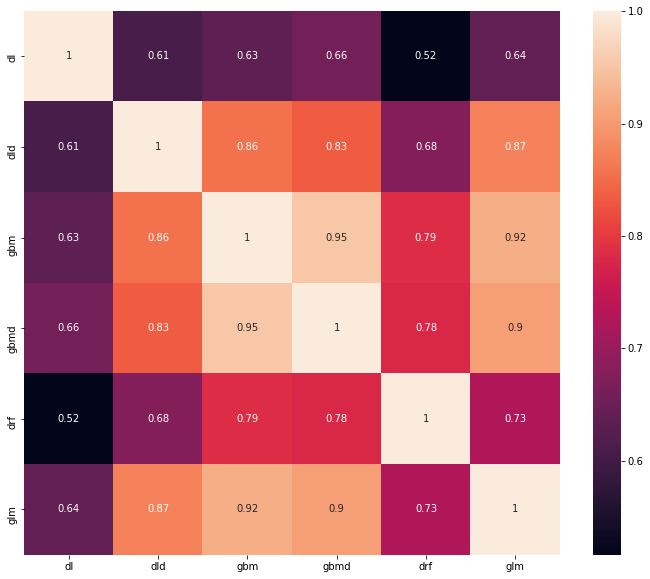

In [142]:
oofs = all_preds.copy()
corr = oofs.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [120]:
oofs1 = oofs[['xgb1', 'xgb4', 'lgb2', 'lgb3','logistic', 'dl','dll', 'drf',
              'drfd','gbmd','glmd']]
oofs.shape, oofs1.shape

((233154, 18), (233154, 11))

In [161]:
test_xgb1 = pd.read_csv('submission/stacking/xgb1.csv')
test_xgb2 = pd.read_csv('submission/stacking/xgb_inter.csv')
test_xgb4 = pd.read_csv('submission/stacking/xgb_inter_3way2.csv')

test_lgb1 = pd.read_csv('submission/stacking/lgb1.csv')
test_lgb2 = pd.read_csv('submission/stacking/lgb_inter.csv')
test_lgb3 = pd.read_csv('submission/stacking/lgb_inter_3way1.csv')

test_ridge = pd.read_csv('submission/stacking/ridge1.csv')
test_logistic = pd.read_csv('submission/stacking/logistic1.csv')

test_dl = pd.read_csv('submission/stacking/dl_model_deep_test.csv')
test_dl_deep = pd.read_csv('submission/stacking/dl_model_deep_test.csv')

test_drf = pd.read_csv('submission/stacking/drf_model_test.csv')
test_drf_deep = pd.read_csv('submission/stacking/drf_model_deep_test.csv')

test_gbm = pd.read_csv('submission/stacking/gbm_model_test.csv')
test_gbm_deep = pd.read_csv('submission/stacking/gbm_model_deep_test.csv')

test_glm_inter = pd.read_csv('submission/stacking/glm_model_bal_test.csv')


In [165]:
tests = np.column_stack([test_xgb1.loan_default, test_xgb2.loan_default,
                         test_xgb4.loan_default, test_lgb1.loan_default,
                         test_lgb2.loan_default, test_lgb3.loan_default,
                         test_ridge.loan_default, test_logistic.loan_default, 
                         test_dl.loan_default, test_dl_deep.loan_default, 
                         test_drf.loan_default, test_drf_deep.loan_default, 
                         test_gbm.loan_default,test_gbm_deep.loan_default, 
                         test_glm_inter.loan_default,
                        ])

tests = pd.DataFrame(data=tests, columns=['xgb1','xgb2','xgb4','lgb1','lgb2','lgb3',
                                          'ridge','logistic','dl','dll','drf',
                                          'drfd','gbm','gbmd','glmd'])
tests.shape

(112392, 15)

In [124]:
oofs1['mean'] = oofs1.mean(axis=1)
tests['mean'] = tests.mean(axis=1)

oofs1['std'] = oofs1.std(axis=1)
tests['std'] = tests.std(axis=1)

oofs1['ridge-logistic'] = oofs['ridge'] - oofs['logistic']
tests['ridge-logistic'] = tests['ridge'] - tests['logistic']

oofs1['xgb2-xgb1'] = oofs['xgb2'] - oofs['xgb1']
tests['xgb2-xgb1'] = tests['xgb2'] - tests['xgb1']

oofs1['glmd-logistic'] = oofs['glmd'] - oofs['logistic']
tests['glmd-logistic'] = tests['glmd'] - tests['logistic']

oofs1['gbm-gbmd'] = oofs['gbm'] - oofs['gbmd']
tests['gbm-gbmd'] = tests['gbm'] - tests['gbmd']

tests.drop(['gbm','xgb2','ridge'], axis=1, inplace=True)
oofs1.shape, tests.shape

((233154, 17), (112392, 17))

In [84]:
roc_auc_score(target, oofs1.mean(axis=1))

0.6621838523014463

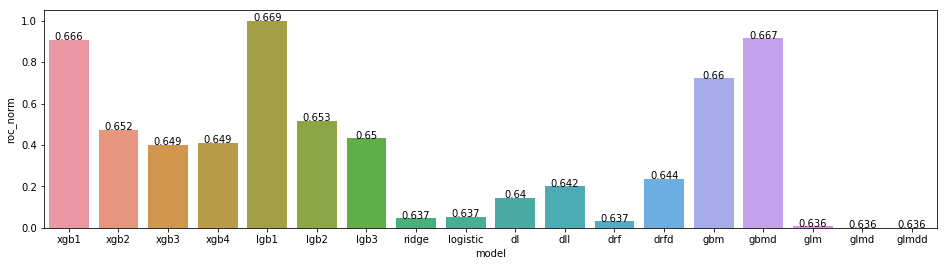

In [81]:
roc_score = {}
for col in oofs.columns:
    roc_score[col] = roc_auc_score(target, oofs[col])
#     print(col.ljust(8), "==>", roc_auc_score(y_valid,preds[col]))
roc_score = pd.DataFrame(data=[roc_score.keys(), roc_score.values()]).T
roc_score.columns = ['model','roc']
roc_score['roc_norm'] = (roc_score.roc - roc_score.roc.min())/ \
                        (roc_score.roc.max() - roc_score.roc.min())

plt.figure(figsize=(16,4))
g = sns.barplot(x='model',y='roc_norm',data=roc_score)

for index, row in roc_score.iterrows():
    g.text(row.name,row.roc_norm, round(row.roc,3), color='black', ha="center")


In [128]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))/1024) for x in dir() if not x.startswith('_') \
    and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('oofs', 32787.3828125),
 ('feat_df', 32395.0390625),
 ('oofs1', 30965.8671875),
 ('train_df', 26867.45703125),
 ('tests', 14927.1640625),
 ('test_df', 12951.5234375),
 ('oof_dl', 3643.1328125),
 ('oof_dl_deep', 3643.1328125),
 ('oof_drf', 3643.1328125),
 ('oof_drf_deep', 3643.1328125),
 ('oof_gbm', 3643.1328125),
 ('oof_gbm_deep', 3643.1328125),
 ('oof_glm', 3643.1328125),
 ('oof_glm_bal', 3643.1328125),
 ('oof_glm_inter', 3643.1328125),
 ('pred', 2634.2890625),
 ('n_unique', 2525.6640625),
 ('target', 1821.6171875),
 ('tr_unique_ids', 1821.6171875),
 ('oof_lgb1', 1821.609375),
 ('oof_lgb2', 1821.609375),
 ('oof_lgb3', 1821.609375),
 ('oof_logistic', 1821.609375),
 ('oof_ridge', 1821.609375),
 ('oof_xgb1', 1821.609375),
 ('oof_xgb2', 1821.609375),
 ('oof_xgb3', 1821.609375),
 ('oof_xgb4', 1821.609375),
 ('sub', 1756.2265625),
 ('test_dl', 1756.2265625),
 ('test_dl_deep', 1756.2265625),
 ('test_drf', 1756.2265625),
 ('test_drf_deep', 1756.2265625),
 ('test_gbm', 1756.2265625),
 ('test

In [130]:
del oof_dl, oof_dl_deep, oof_drf, oof_drf_deep, oof_gbm, oof_gbm_deep, oof_glm
del oof_glm_inter, oof_lgb1, oof_lgb2, oof_lgb3, oof_xgb1, oof_xgb2, oof_xgb3
gc.collect()

9885

In [125]:
train = h2o.H2OFrame(pd.concat([oofs1, target], axis=1))                     
test  = h2o.H2OFrame(tests)
print(train.shape, test.shape)

x = train.columns
y = "loan_default"
x.remove(y)

train[y] = train[y].asfactor()
gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(233154, 18) (112392, 17)


0

gbm Model Build progress: |███████████████████████████████████████████████| 100%
[[0.33405112681309257, 0.7839239301062817]]


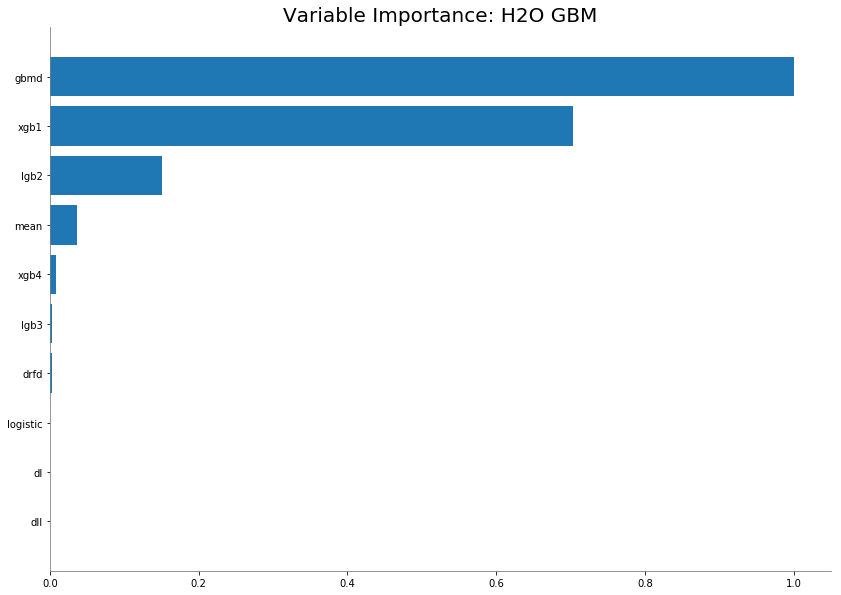

In [126]:
gbm_model_meta = H2OGradientBoostingEstimator(  nfolds=3, seed=1234,
                                                fold_assignment = 'stratified',
                                                ntrees = 10000,
                                                learn_rate = 0.05,
                                                max_depth = 3,
                                                stopping_rounds = 5, 
                                                stopping_tolerance = 1e-3,
                                                stopping_metric = "AUC",
                                                sample_rate = 0.7,
                                                col_sample_rate = 0.7,
                                                keep_cross_validation_predictions=True
                                             )
gbm_model_meta.train(x, y, training_frame=train)#, validation_frame=test)
print(gbm_model_meta.accuracy())

# model_path = h2o.save_model(model=gbm_model_deep, path="submission/stacking/", force=True)
# print(model_path)

# pred = gbm_model_deep.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("gbm_model_deep_test", pred_p1, ts_unique_ids, sub)

# oof = gbm_model_deep.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("gbm_model_deep_oof", oof_p1, tr_unique_ids, sub)

# del gbm_model_deep, pred, pred_p1, oof, oof_p1
# gc.collect()



gbm_model_meta.varimp_plot()

                                                             

In [94]:
pred = gbm_model_meta.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("gbm_model_meta_test", pred_p1, ts_unique_ids, sub)


gbm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved


In [114]:
# del dl_model_meta
gc.collect()


8

drf Model Build progress: |███████████████████████████████████████████████| 100%
[[0.25829626227602764, 0.857196055935401]]


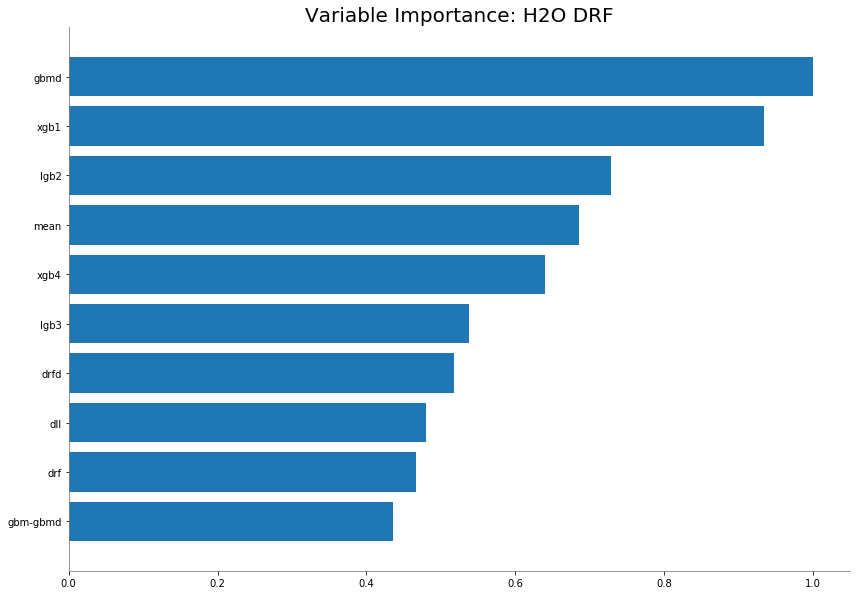

In [131]:
drf_model_meta = H2ORandomForestEstimator( nfolds=3, seed=1234,
                                           keep_cross_validation_predictions=True,
                                           fold_assignment = 'stratified',
#                                            histogram_type = 'QuantilesGlobal',
#                                            categorical_encoding = 'eigen',
                                           stopping_metric = 'auc',
                                           ntrees = 200,
                                           balance_classes = True
                                           )
drf_model_meta.train(x, y, training_frame=train)#, validation_frame=test)
print(drf_model_meta.accuracy())


# model_path = h2o.save_model(model=drf_model_deep, path="submission/stacking/", force=True)
# print(model_path)

# pred = drf_model_deep.predict(test)
# pred = pred.as_data_frame()
# pred_p1 = pred['p1'].values
# make_h20_prediction("drf_model_deep_test", pred_p1, ts_unique_ids, sub)

# oof = drf_model_deep.cross_validation_holdout_predictions()
# oof = oof.as_data_frame()
# oof_p1 = oof['p1'].values
# make_h20_prediction("drf_model_deep_oof", oof_p1, tr_unique_ids, sub)

# del drf_model_deep, pred, pred_p1, oof, oof_p1
# gc.collect()




drf_model_meta.varimp_plot()

In [104]:
pred = gbm_model_meta.predict(test)
pred = pred.as_data_frame()
pred_p1 = pred['p1'].values
make_h20_prediction("drf_model_meta_test", pred_p1, ts_unique_ids, sub)


gbm prediction progress: |████████████████████████████████████████████████| 100%
successfully saved


In [132]:
# for key in files.keys():
#     _submission[key + '_rank'] = _submission[key].rank()


# _submission['rank_sum'] = np.sum(
#         _submission[col] for col in _submission.columns if '_rank' in col)
# _submission['target'] = _submission['rank_sum']/(len(files) *
#         _submission.shape[0])

# # take the first (id) and last column (target)
# submission = _submission.iloc[:, [0, -1]]


5218

In [139]:
print(roc_auc_score(target, oofs1.mean(1)))

0.6593400488284036


In [140]:
reduce_mem_usage_wo_print(oofs1)
reduce_mem_usage_wo_print(oofs)


Memory 30.24 MB ==>  7.56 MB
Decreased by 75.0%
Memory 32.02 MB ==>  8.00 MB
Decreased by 75.0%


In [142]:
# print(roc_auc_score(target, oofs1.mean(1)))
oofs2 = oofs1.rank()
oofs2 = oofs2/oofs2.max()
oofs2.max()

xgb1              1.0
xgb4              1.0
lgb2              1.0
lgb3              1.0
logistic          1.0
dl                1.0
dll               1.0
drf               1.0
drfd              1.0
gbmd              1.0
glmd              1.0
mean              1.0
std               1.0
ridge-logistic    1.0
xgb2-xgb1         1.0
glmd-logistic     1.0
gbm-gbmd          1.0
dtype: float64

In [156]:
oofs2 = oofs1[['xgb1','lgb3','drf','drfd','gbmd']].rank()
oofs2 = oofs2/oofs2.max()
print(roc_auc_score(target, oofs2.mean(1)))


0.6628418953354298


In [158]:
oofs2 = tests[['xgb1','lgb3','drf','drfd','gbmd']].rank()
oofs2 = oofs2/oofs2.max()

test_ranking = test_dl.copy()
test_ranking['loan_default'] = oofs2.mean(1)

test_ranking.to_csv('submission/stacking/ranking.csv', index=None)

In [163]:
oofs2 = oofs[['xgb1','lgb1']].rank()
oofs2 = oofs2/oofs2.max()
print(roc_auc_score(target, oofs2.mean(1)))



0.6688537095575291


In [167]:
oofs2 = tests[['xgb1','lgb1']].rank()
oofs2 = oofs2/oofs2.max()

# test_ranking = test_dl.copy()
test_ranking['loan_default'] = oofs2.mean(1)

test_ranking.to_csv('submission/stacking/ranking1.csv', index=None)

In [143]:
print(roc_auc_score(target, oofs1.mean(1)))
print(roc_auc_score(target, oofs2.mean(1)))


0.6593350272256364
0.6539313625666187


In [53]:
# # make_prediction("cat_stratified", pred_cat1, ts_unique_ids, sub)

# model_ridge, oof_ridge, pred_ridge = run_cv_linear(#train_df, target, 
#                                                    #test_df,'logistic')
#     feature_df.iloc[:target.shape[0]], target, 
#     feature_df.iloc[target.shape[0]:].reset_index(drop=True),
#     'ridge')

# make_prediction("ridge_inter", pred_ridge, ts_unique_ids, sub)
# np.save('submission/stacking/oof_ridge_inter.npy',oof_ridge)
# del oof_ridge, pred_ridge
# gc.collect()

In [276]:
# inter_cols = ['ltv','disbursed_amount','asset_cost','supplied_id', 'age(in year)',
#      'credit_hist_total_month', 'loan_tenure_total_month','PRI.CURRENT.BALANCE',
#      'PRI.DISBURSED.AMOUNT','PRI.SANCTIONED.AMOUNT','Bureau_desc']

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# glm_model_inter = H2OGeneralizedLinearEstimator(nfolds=2, seed=1234,
#                                                 keep_cross_validation_predictions=True,
#                                                 fold_assignment = 'stratified',
#                                                 ignored_columns = drop_cols,
#                                                 interactions = inter_cols,
#                                                 family="binomial", 
#                                                 lambda_search=True,
#                                                 balance_classes=True,
#                                                 remove_collinear_columns = True)
# glm_model_inter.train(x, y, training_frame=train, validation_frame=test)
# glm_model_inter.std_coef_plot()


In [84]:

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','loan_tenure_year','disbursal_month','Aadhar_flag',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# kmeans_model = H2OKMeansEstimator( k=2, 
# #                                    fold_assignment = 'stratified',
#                                    keep_cross_validation_predictions=True, 
#                                    nfolds = 3,
#                                    ignored_columns = drop_cols,
#                                    seed=1234,
#                                    categorical_encoding = 'one_hot_explicit',
#                                    estimate_k = True,
#                                    max_iterations = 1000
                                   
#                                   )
# kmeans_model.train(x, y,training_frame=train, validation_frame=test)


kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [42]:

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# xgboost_model = H2OXGBoostEstimator(ntrees = 10000,
#                                     max_bins=128,
#                                     col_sample_rate=0.7,
#                                     fold_assignment = 'stratified',
#                                     eta = 0.1,
#                                     keep_cross_validation_predictions=True, 
#                                     nfolds = 3,
#                                     ignored_columns = drop_cols,
#                                     seed=1234,
#                                     categorical_encoding = 'one_hot_explicit',
#                                     grow_policy = 'depthwise', #lossguide(lgbm)
#                                     max_depth = 5,
#                                     min_child_weight = 3,
#                                     quiet_mode = False,
#                                     reg_lambda = 1.5,
#                                     sample_rate=0.7,
#                                     stopping_metric='auc',
#                                     stopping_rounds=25,
#                                     subsample=.7
#                                   )

# xgboost_model.train(x, y,training_frame=train, validation_frame=test)
# xgboost_model.varimp_plot()

In [ ]:

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# xgboost_model1 = H2OXGBoostEstimator(ntrees = 10000,
#                                     max_bins=63,
#                                     col_sample_rate=0.5,
#                                     fold_assignment = 'stratified',
#                                     eta = 0.2,
#                                     keep_cross_validation_predictions=True, 
#                                     nfolds = 3,
#                                     ignored_columns = drop_cols,
#                                     seed=1234,
#                                     categorical_encoding = 'eigen',
#                                     grow_policy = 'depthwise', #lossguide(lgbm)
#                                     max_depth = 4,
#                                     min_child_weight = 5,
#                                     quiet_mode = False,
#                                     reg_lambda = 1.5,
#                                     sample_rate=0.5,
#                                     stopping_metric='auc',
#                                     stopping_rounds=15,
#                                     subsample=.5
#                                   )

# xgboost_model1.train(x, y,training_frame=train, validation_frame=test)
# xgboost_model1.varimp_plot()

In [74]:

# drop_cols = ['no_of_acc', 'NO.OF_INQUIRIES','new_acc_past_month',
#     'no_of_acc_overdue','Aadhar_flag',#'loan_tenure_year','disbursal_month',
#     'PAN_flag','SEC.NO.OF.ACCTS','SEC.ACTIVE.ACCTS','SEC.SANCTIONED.AMOUNT',
#     'SEC.DISBURSED.AMOUNT','SEC.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.INSTAL.AMT',
#     'Passport_flag','VoterID_flag','DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

# lgbm_model = H2OXGBoostEstimator(   ntrees = 10000,
#                                     max_bins=128,
#                                     col_sample_rate=0.7,
#                                     fold_assignment = 'stratified',
#                                     eta = 0.1,
#                                     keep_cross_validation_predictions=True, 
#                                     nfolds = 3,
#                                     ignored_columns = drop_cols,
#                                     seed=1234,
#                                     categorical_encoding = 'one_hot_explicit',
#                                     grow_policy = 'lossguide', #lossguide(lgbm)
#                                     max_depth = 5,
#                                     min_child_weight = 3,
#                                     quiet_mode = False,
#                                     reg_lambda = 1.5,
#                                     sample_rate=0.7,
#                                     stopping_metric='auc',
#                                     stopping_rounds=25,
#                                     subsample=.7
#                                   )

# lgbm_model.train(x, y,training_frame=train, validation_frame=test)
# lgbm_model.varimp_plot()

In [180]:
# glm_model_poison = H2OGeneralizedLinearEstimator(balance_classes=True)
# glm_model_poison.train(x, y, training_frame=train, validation_frame=test)
# glm_model_poison.std_coef_plot()

In [181]:
# glm_model_gauss = H2OGeneralizedLinearEstimator(family="gaussian", balance_classes=True)
# glm_model_gauss.train(x, y, training_frame=train, validation_frame=test)
# glm_model_gauss.std_coef_plot()

In [41]:
# dl_model.cross_validation_holdout_predictions()

In [40]:
# dl_pred  = dl_model.predict(test)
# drf_pred = drf_model.predict(test)
# gbm_pred = gbm_model.predict(test)
# glm_pred = glm_model.predict(test)

# dl_pred_deep  = dl_model_deep.predict(test)
# drf_pred_deep = drf_model_deep.predict(test)
# gbm_pred_deep = gbm_model_deep.predict(test)
# glm_pred_bal = glm_model_bal.predict(test)
# glm_pred_inter = glm_model_inter.predict(test)

In [185]:
dl_pred  = dl_pred.as_data_frame()
drf_pred = drf_pred.as_data_frame()
gbm_pred = gbm_pred.as_data_frame()
glm_pred = glm_pred.as_data_frame()

dl_pred_deep  = dl_pred_deep.as_data_frame()
drf_pred_deep = drf_pred_deep.as_data_frame()
gbm_pred_deep = gbm_pred_deep.as_data_frame()
glm_pred_bal = glm_pred_bal.as_data_frame()


deeplearning prediction progress: |███████████████████████████████████████| 100%


In [186]:
preds = pd.concat([dl_pred.p1, drf_pred.p1, gbm_pred.p1, glm_pred.p1,
                  dl_pred_deep.p1, drf_pred_deep.p1, gbm_pred_deep.p1, 
                   glm_pred_bal.p1], axis=1)
preds.columns = ['dl','drf','gbm','glm', 'dl_deep','drf_deep','gbm_deep','glm_bal']
preds.shape

,dl,drf,gbm,glm,dl_deep,drf_deep,gbm_deep,glm_bal
0,0.182448,0.264779,0.210978,0.171692,0.149249,0.184799,0.212343,0.173547
1,0.267999,0.206690,0.182956,0.179967,0.182160,0.218147,0.169924,0.181964
2,0.106926,0.075144,0.167387,0.117219,0.077468,0.163256,0.137420,0.118710
3,0.302675,0.226323,0.280184,0.238831,0.258159,0.234431,0.284284,0.239180
4,0.285455,0.147643,0.252083,0.202511,0.182790,0.197310,0.261351,0.203754
5,0.221472,0.181705,0.208331,0.201607,0.211161,0.229546,0.184833,0.201902
6,0.052326,0.022469,0.051031,0.046827,0.023359,0.085004,0.039418,0.051872
7,0.781469,0.499005,0.517551,0.378265,0.732050,0.292351,0.557703,0.383853
8,0.117889,0.080915,0.104588,0.089360,0.070048,0.158102,0.089385,0.092123
9,0.216252,0.163137,0.154389,0.158212,0.160184,0.197986,0.157145,0.157542


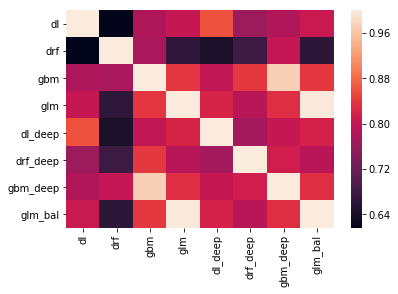

In [187]:
import seaborn as sns
corr = preds.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [192]:
pred = lgb2.predict(x_valid, num_iteration=lgb2.best_iteration)
pred.shape, preds.shape

((58288,), (58288, 8))

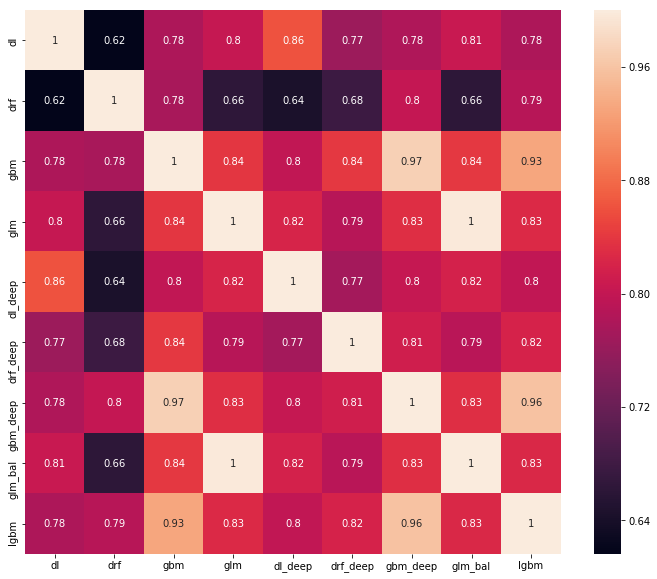

In [197]:
preds = pd.concat([preds, pd.DataFrame(data=pred,columns=['lgbm'])], axis=1)
import seaborn as sns
corr = preds.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [209]:
roc_score = {}
for col in preds.columns:
    roc_score[col] = roc_auc_score(y_valid, preds[col])
#     print(col.ljust(8), "==>", roc_auc_score(y_valid,preds[col]))
roc_score = pd.DataFrame(data=[roc_score.keys(), roc_score.values()]).T
roc_score.columns = ['model','roc']
roc_score['roc_norm'] = (roc_score.roc - roc_score.roc.min())/ \
                        (roc_score.roc.max() - roc_score.roc.min())

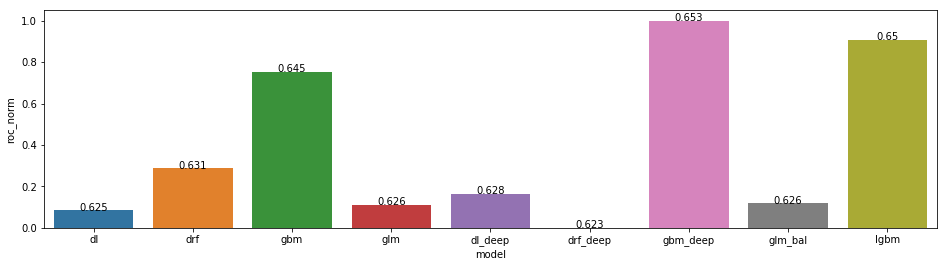

In [221]:
plt.figure(figsize=(16,4))
g = sns.barplot(x='model',y='roc_norm',data=roc_score)

for index, row in roc_score.iterrows():
    g.text(row.name,row.roc_norm, round(row.roc,3), color='black', ha="center")


In [198]:
train1 = h2o.H2OFrame(pd.concat([preds, target], axis=1))
# test  = h2o.H2OFrame(pd.concat([train_df, target], axis=1).drop(
#     ['disbursal_week', 'disbursal_day'], axis=1).iloc[valid_index])
# print(train.shape, test.shape)

# del train_df1, valid_df
gc.collect()

x = train1.columns
y = "loan_default"
x.remove(y)

# ignored_columns = ['UniqueID']
train1[y] = train1[y].asfactor()
# test[y]  = test[y].asfactor()

# aml = H2OAutoML(max_models=20, seed=1337, max_runtime_secs=14400, nfolds=3)
# aml.train(x = x, y = y,
#           training_frame = train,
#           leaderboard_frame = test)
# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%


0

gbm Model Build progress: |███████████████████████████████████████████████| 100%


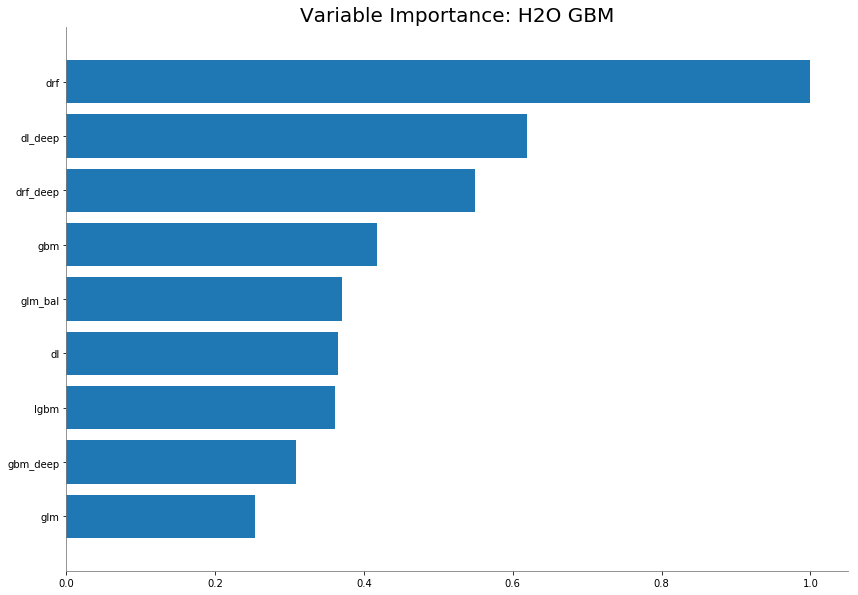

In [222]:
gbm_model_meta = H2OGradientBoostingEstimator()
gbm_model_meta.train(x, y, training_frame=train1)#, validation_frame=test)
gbm_model_meta.varimp_plot()

glm Model Build progress: |███████████████████████████████████████████████| 100%


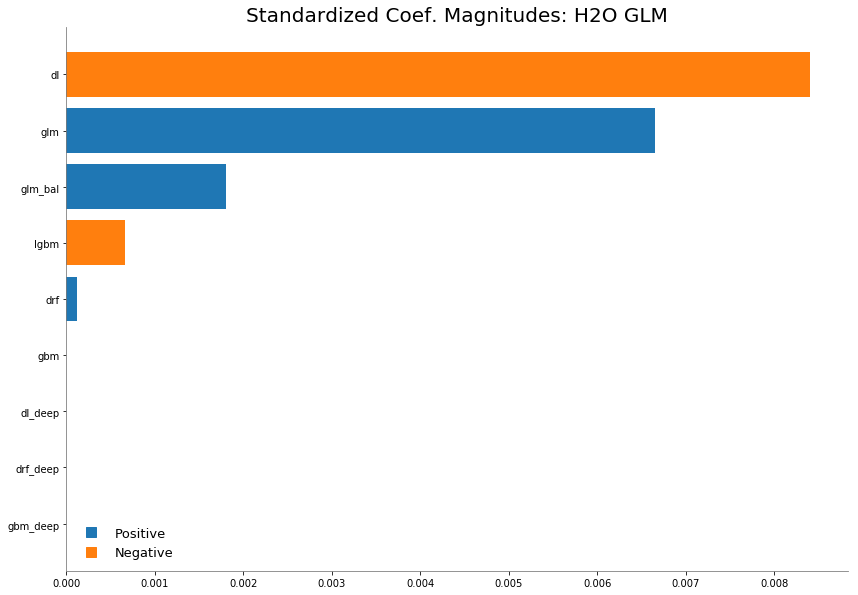

In [225]:
glm_model_meta = H2OGeneralizedLinearEstimator(family="binomial", 
                                              lambda_search=True,
                                              balance_classes=True)
glm_model_meta.train(x, y, training_frame=train1)#, validation_frame=test)
glm_model_meta.std_coef_plot()


In [227]:
glm_model_bal

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1555663391569_328


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15721448260372806
RMSE: 0.3965028153793212
LogLoss: 0.488951306812704
Null degrees of freedom: 174865
Residual degrees of freedom: 174824
Null deviance: 177926.8641156018
Residual deviance: 171001.9184342206
AIC: 171085.9184342206
AUC: 0.6395501273778413
Gini: 0.2791002547556827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1973200098954884: 


,0,1,Error,Rate
0,69701.0,69124.0,0.4979,(69124.0/138825.0)
1,10868.0,25173.0,0.3015,(10868.0/36041.0)
Total,80569.0,94297.0,0.4574,(79992.0/174866.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1973200,0.3862726,236.0
max f2,0.1293098,0.5744969,314.0
max f0point5,0.2505655,0.3227946,170.0
max accuracy,0.4951678,0.7939108,32.0
max precision,0.4951678,0.5040872,32.0
max recall,0.0016625,1.0,399.0
max specificity,0.9684359,0.9999928,0.0
max absolute_mcc,0.2061088,0.1641090,226.0
max min_per_class_accuracy,0.2160535,0.5988547,214.0
max mean_per_class_accuracy,0.2061088,0.6014157,226.0


Gains/Lift Table: Avg response rate: 20.61 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100019,0.4095436,2.2913888,2.2913888,0.4722699,0.4722699,0.0229183,0.0229183,129.1388775,129.1388775
,2,0.0200039,0.3758300,1.9057919,2.0985903,0.3927959,0.4325329,0.0190616,0.0419800,90.5791874,109.8590324
,3,0.0300001,0.3571765,1.8069582,2.0014167,0.3724256,0.4125048,0.0180628,0.0600427,80.6958189,100.1416674
,4,0.0400021,0.3435482,1.7643139,1.9421325,0.3636364,0.4002859,0.0176466,0.0776893,76.4313875,94.2132500
,5,0.0500040,0.3335257,1.6117396,1.8760464,0.3321898,0.3866651,0.0161205,0.0938098,61.1739562,87.6046355
,6,0.1000023,0.3016530,1.5455151,1.7107902,0.3185405,0.3526048,0.0772731,0.1710829,54.5515142,71.0790200
,7,0.1500006,0.2816302,1.4606089,1.6273996,0.3010408,0.3354175,0.0730279,0.2441109,46.0608924,62.7399620
,8,0.2000046,0.2669923,1.3761003,1.5645712,0.2836231,0.3224681,0.0688105,0.3129214,37.6100255,56.4571186
,9,0.3000011,0.2436638,1.2619395,1.4636978,0.2600938,0.3016775,0.1261896,0.4391110,26.1939473,46.3697795
,10,0.4000034,0.2237805,1.1700296,1.3902797,0.2411506,0.2865455,0.1170056,0.5561166,17.0029561,39.0279687




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18292881581801923
RMSE: 0.42770178374425705
LogLoss: 0.5508834674433378
Null degrees of freedom: 58287
Residual degrees of freedom: 58246
Null deviance: 66203.36922160786
Residual deviance: 64321.463153369165
AIC: 64405.463153369165
AUC: 0.6261606701062149
Gini: 0.2523213402124298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17718249591262442: 


,0,1,Error,Rate
0,18006.0,25712.0,0.5881,(25712.0/43718.0)
1,3462.0,11108.0,0.2376,(3462.0/14570.0)
Total,21468.0,36820.0,0.5005,(29174.0/58288.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1771825,0.4323020,261.0
max f2,0.0905986,0.6288908,353.0
max f0point5,0.2432195,0.3618127,176.0
max accuracy,0.6198176,0.7500515,14.0
max precision,0.6198176,0.5161290,14.0
max recall,0.0011427,1.0,399.0
max specificity,0.9856560,0.9999543,0.0
max absolute_mcc,0.1960100,0.1602377,237.0
max min_per_class_accuracy,0.2114072,0.5886363,216.0
max mean_per_class_accuracy,0.1960100,0.5922777,237.0


Gains/Lift Table: Avg response rate: 25.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100021,0.4002093,1.8321554,1.8321554,0.4579760,0.4579760,0.0183253,0.0183253,83.2155408,83.2155408
,2,0.0200041,0.3707123,1.7772594,1.8047074,0.4442539,0.4511149,0.0177763,0.0361016,77.7259365,80.4707386
,3,0.0300062,0.3515185,1.7429493,1.7841214,0.4356775,0.4459691,0.0174331,0.0535347,74.2949339,78.4121371
,4,0.0400082,0.3390373,1.5851232,1.7343718,0.3962264,0.4335334,0.0158545,0.0693892,58.5123218,73.4371832
,5,0.0500103,0.3294361,1.5165032,1.6907981,0.3790738,0.4226415,0.0151682,0.0845573,51.6503165,69.0798099
,6,0.1000034,0.2978209,1.4291598,1.5600014,0.3572409,0.3899468,0.0714482,0.1560055,42.9159775,56.0001380
,7,0.1500137,0.2780766,1.3682839,1.4960882,0.3420240,0.3739707,0.0684283,0.2244338,36.8283851,49.6088229
,8,0.2000069,0.2638064,1.3618890,1.4625442,0.3404255,0.3655859,0.0680851,0.2925189,36.1889046,46.2544189
,9,0.3000103,0.2413631,1.2662572,1.3971152,0.3165208,0.3492309,0.1266301,0.4191489,26.6257169,39.7115182
,10,0.3999966,0.2216614,1.1017298,1.3232783,0.2753946,0.3307742,0.1101579,0.5293068,10.1729798,32.3278338



Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2019-04-19 15:13:49,0.000 sec,1,.81E-1,1,1.0175041,1.1357976
,2019-04-19 15:13:49,0.117 sec,2,.73E-1,2,1.0161151,1.1344012
,2019-04-19 15:13:49,0.184 sec,3,.67E-1,2,1.0148837,1.1331859
,2019-04-19 15:13:49,0.227 sec,4,.61E-1,3,1.0132723,1.1316863
,2019-04-19 15:13:49,0.266 sec,5,.56E-1,3,1.0113747,1.1299877
---,---,---,---,---,---,---,---
,2019-04-19 15:13:54,5.586 sec,49,.93E-3,41,0.9781337,1.1035349
,2019-04-19 15:13:54,5.734 sec,50,.84E-3,41,0.9780624,1.1035220
,2019-04-19 15:13:55,5.989 sec,51,.77E-3,42,0.9779999,1.1035182
,2019-04-19 15:13:55,6.196 sec,52,.7E-3,42,0.9779478,1.1035151



See the whole table with table.as_data_frame()


In [155]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

splits = 4
random_seed = 2019
features = train_df.columns
param = {
    'bagging_freq'           : 5,
    'bagging_fraction'       : 0.33,
    'boost_from_average'     : 'false',
    'boost'                  : 'gbdt',
    'feature_fraction'       : 0.3,
    'learning_rate'          : 0.01,
    'max_depth'              : -1,
    'metric'                 : 'auc',
    'min_data_in_leaf'       : 100,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves'             : 30,
    'num_threads'            : 4,
    'tree_learner'           : 'serial',
    'objective'              : 'binary',
    'verbosity'              : 1,
#     'lambda_l1'              : 0.001,
    'lambda_l2'              : 0.5
}   

n_splits = splits
num_round = 10000
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
oof_lgb = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

temp = train_df.apply(lambda x: pd.Series.value_counts(x).shape[0])
cat_columns = list(temp[temp<50].index)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print(trn_idx.shape, val_idx.shape)
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns)

    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx],
                          feature_name=list(train_df.columns))#,
#                           categorical_feature=cat_columns) 

    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=50, early_stopping_rounds = 25)
    oof_lgb[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    print( "  auc = ", roc_auc_score(target.iloc[val_idx], oof_lgb[val_idx]) )
    print("="*60)

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof_lgb)))

# sub_df = pd.DataFrame({"ID_code":test_id})
# sub_df["target"] = predictions

# sub_df.columns = sub.columns
# sub_df.to_csv('submission/lightgbm_target_{}.csv'.format(file_path), index=None)


lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
lgb_imp.columns = ['feature','imp']
lgb_imp = lgb_imp.sort_values(by='imp', ascending=False)
plt.figure(figsize=(12,15))
plt.barh(lgb_imp.feature, lgb_imp.imp)

(174865,) (58289,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[50]	training's auc: 0.660532	valid_1's auc: 0.64924
[100]	training's auc: 0.662125	valid_1's auc: 0.650493
[150]	training's auc: 0.663824	valid_1's auc: 0.651822
[200]	training's auc: 0.66611	valid_1's auc: 0.65321
[250]	training's auc: 0.669116	valid_1's auc: 0.655472
[300]	training's auc: 0.671336	valid_1's auc: 0.656946
[350]	training's auc: 0.673914	valid_1's auc: 0.658606
[400]	training's auc: 0.676017	valid_1's auc: 0.659976
[450]	training's auc: 0.678017	valid_1's auc: 0.661093
[500]	training's auc: 0.680351	valid_1's auc: 0.662147
[550]	training's auc: 0.682148	valid_1's auc: 0.663052
[600]	training's auc: 0.683902	valid_1's auc: 0.663925
[650]	training's auc: 0.68565	valid_1's auc: 0.664514
[700]	training's auc: 0.687061	valid_1's auc: 0.664931
[750]	training's auc: 0.688567	valid_1's auc: 0.665451
[800]	training's auc: 0.690017	valid_1's auc: 0.665962
[850]	training's auc: 0.691388	valid_

KeyboardInterrupt: 